In [1]:
! pip install miceforest

Looking in links: /kaggle/input/pm-76086203-at-02-06-2025-17-12-47/


# Load packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import numpy as np, pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from miceforest import ImputationKernel

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping

from scipy.stats import rankdata

# Import pandas profiling library
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


#loading datasets

In [3]:
data_dictionary = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv")
data_dictionary

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


In [4]:
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


# EDA and Preproccessing

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [6]:
train.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,24606.000000,28800.000000,24499.000000,26992.000000,26235.000000,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,1.773795,2015.179444,1.703743,42.511591,1.719916,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,0.427130,3.153914,0.462213,15.251434,0.454449,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2008.000000,0.000000,18.010000,0.000000,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,2.000000,2013.000000,1.000000,28.447000,1.000000,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2016.000000,2.000000,40.063000,2.000000,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2018.000000,2.000000,56.131500,2.000000,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2020.000000,2.000000,84.800000,2.000000,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [7]:
df = pd.DataFrame(columns=['Column', 'Data Type' , 'Missing Count', 'Percentage'])

# Get columns with missing values
missing_columns = train.columns[train.isnull().any()].tolist()
for col in missing_columns:
    data_type = data_dictionary[data_dictionary['variable']==col]['type']
    missin_count = train[col].isnull().sum()
    total_count = len(train[col])
    pencentage = missin_count*100/total_count
    df.loc[len(df)] = [col,data_type,missin_count,pencentage]

df.sort_values(by='Percentage',ascending=False)

,Column,Data Type,Missing Count,Percentage
27,tce_match,"32 Categorical Name: type, dtype: object",18996,65.958333
25,mrd_hct,"30 Categorical Name: type, dtype: object",16597,57.628472
21,cyto_score_detail,"25 Categorical Name: type, dtype: object",11923,41.399306
42,tce_div_match,"49 Categorical Name: type, dtype: object",11396,39.569444
15,tce_imm_match,"18 Categorical Name: type, dtype: object",11133,38.656250
2,cyto_score,"2 Categorical Name: type, dtype: object",8068,28.013889
13,hla_high_res_10,"16 Numerical Name: type, dtype: object",7163,24.871528
5,hla_high_res_8,"5 Numerical Name: type, dtype: object",5829,20.239583
11,hla_high_res_6,"14 Numerical Name: type, dtype: object",5284,18.347222
14,hla_match_dqb1_high,"17 Numerical Name: type, dtype: object",5199,18.052083


As `tce_match` and `mrd_hct` have a lot of missing value. I drop them.

In [8]:
train = train.drop(['tce_match','mrd_hct'],axis=1)
test = test.drop(['tce_match','mrd_hct'],axis=1)

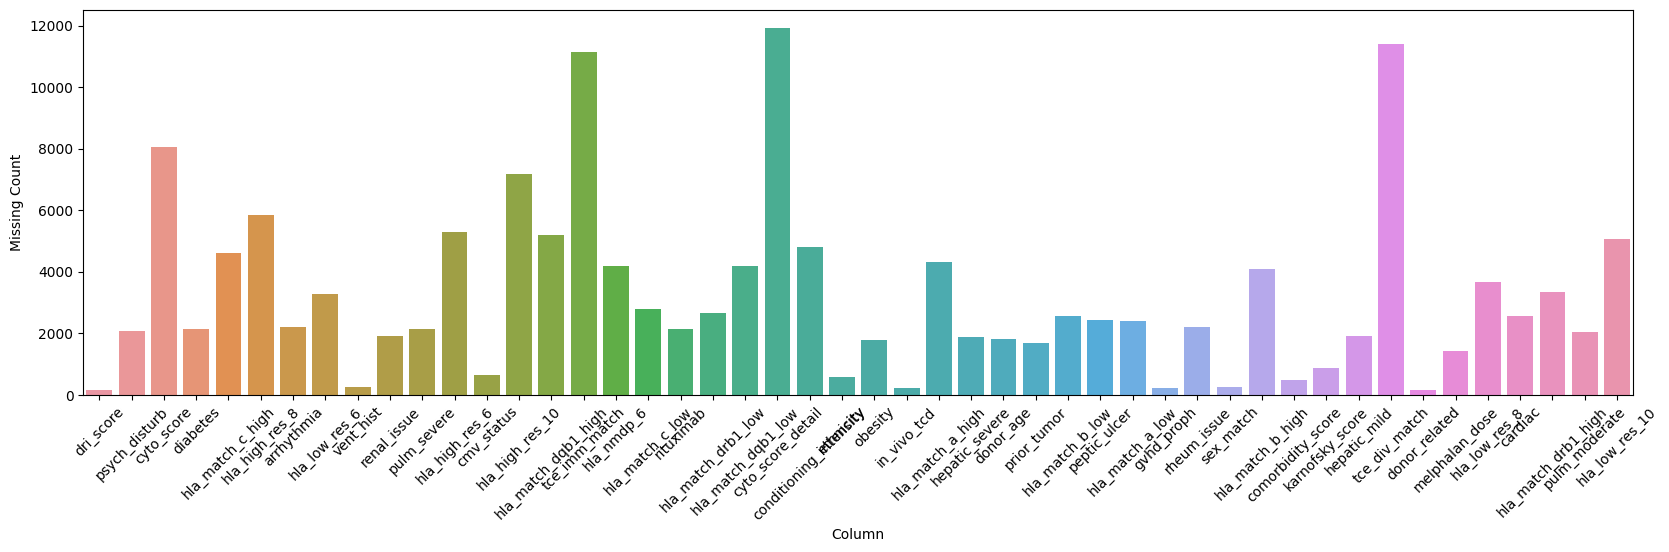

In [9]:
df = df[df['Column'] != 'tce_match']
df = df[df['Column'] != 'mrd_hct']

missing_columns.remove('tce_match')
missing_columns.remove('mrd_hct')
fig = plt.figure(figsize=(20,5))
sns.barplot(data=df,x='Column',y='Missing Count')
plt.xticks(rotation=45)
plt.show()

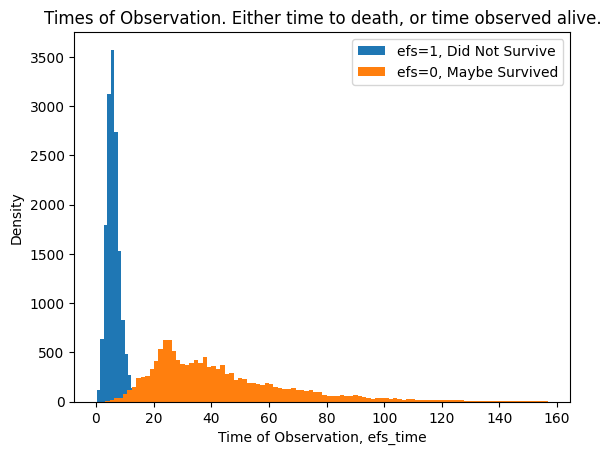

In [10]:
plt.hist(train.loc[train['efs']==1,"efs_time"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train['efs']==0,"efs_time"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to death, or time observed alive.")
plt.legend()
plt.show()

## Feature engineering
Now lets make new features:

In [11]:
def make_new_hla(train):
  train['hla_nmdp_6'] = (train['hla_match_a_low'].fillna(0) + train['hla_match_b_low'].fillna(0) + train['hla_match_drb1_high'].fillna(0))

  train['hla_low_res_6'] = (train['hla_match_a_low'].fillna(0) + train['hla_match_b_low'].fillna(0) + train['hla_match_drb1_low'].fillna(0))

  train['hla_high_res_6'] = (train['hla_match_a_high'].fillna(0) + train['hla_match_b_high'].fillna(0) + train['hla_match_drb1_high'].fillna(0))

  train['hla_low_res_8'] = (train['hla_match_a_low'].fillna(0) + train['hla_match_b_low'].fillna(0) + train['hla_match_c_low'].fillna(0)
                              + train['hla_match_drb1_low'].fillna(0))

  train['hla_high_res_8'] = (train['hla_match_a_high'].fillna(0) + train['hla_match_b_high'].fillna(0) + train['hla_match_c_high'].fillna(0)
                              + train['hla_match_drb1_high'].fillna(0))

  train['hla_low_res_10'] = (train['hla_match_a_low'].fillna(0) + train['hla_match_b_low'].fillna(0) + train['hla_match_c_low'].fillna(0)
                              + train['hla_match_drb1_low'].fillna(0) + train['hla_match_dqb1_low'].fillna(0) )

  train['hla_high_res_10'] = (train['hla_match_a_high'].fillna(0) + train['hla_match_b_high'].fillna(0) + train['hla_match_c_high'].fillna(0)
                              + train['hla_match_drb1_high'].fillna(0) + train['hla_match_dqb1_high'].fillna(0))

  train = train.drop(['hla_match_a_low','hla_match_b_low','hla_match_c_low','hla_match_a_high','hla_match_b_high','hla_match_c_high',
                        'hla_match_drb1_high','hla_match_drb1_low','hla_match_dqb1_high','hla_match_dqb1_low'],axis=1)

  return train


In [12]:
train= make_new_hla(train)
test=make_new_hla(test)

In [13]:
train.shape

(28800, 48)

### plot some boxplot and countplot

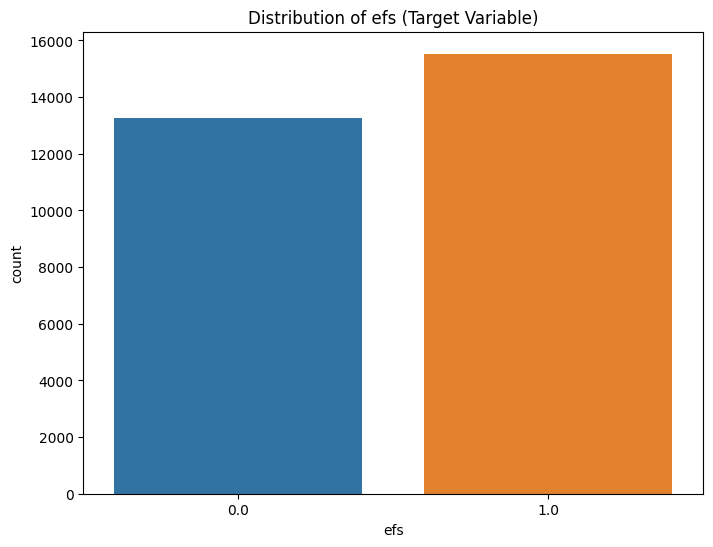

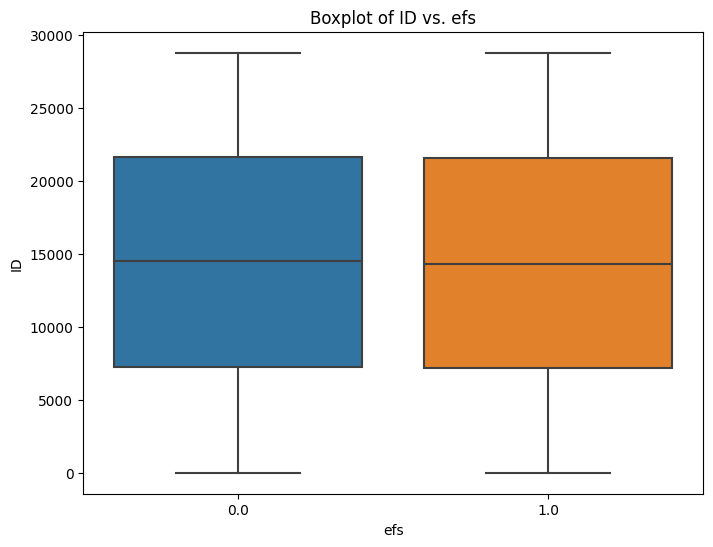

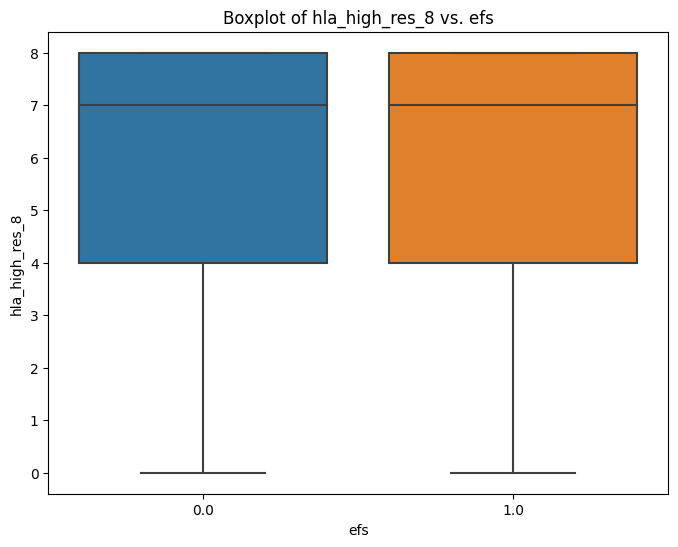

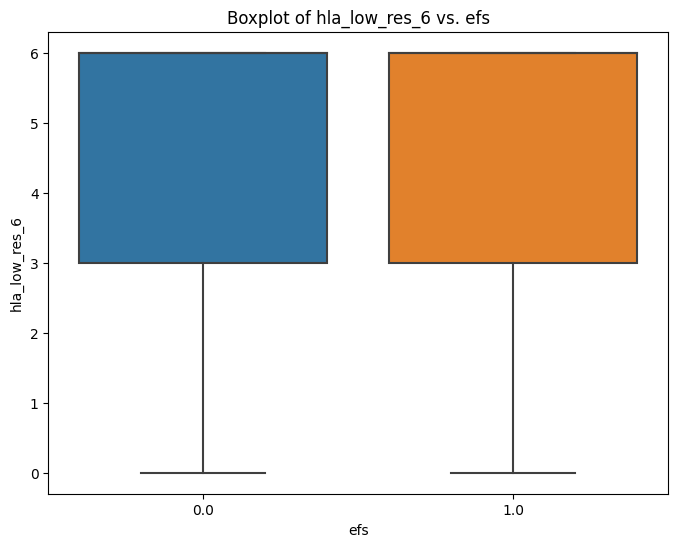

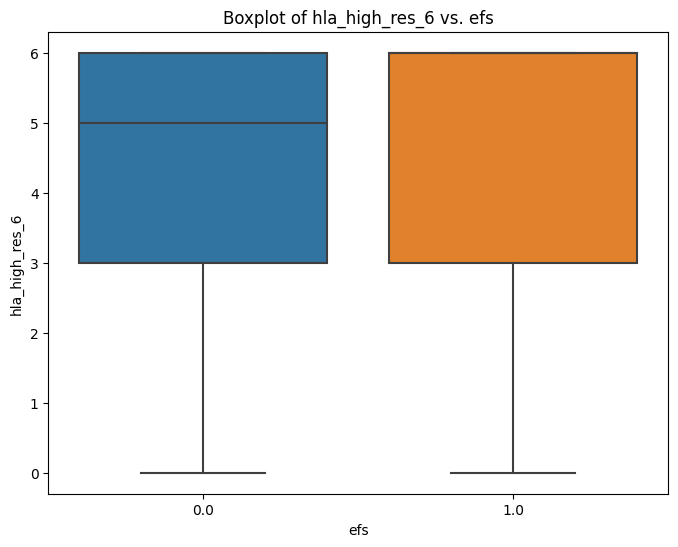

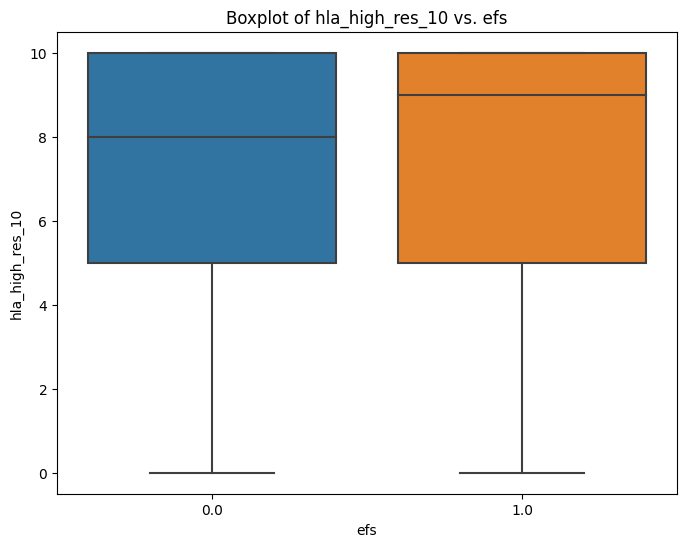

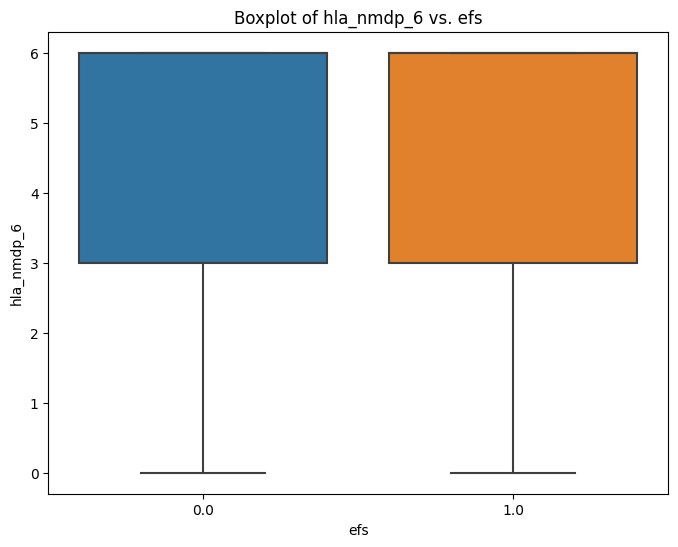

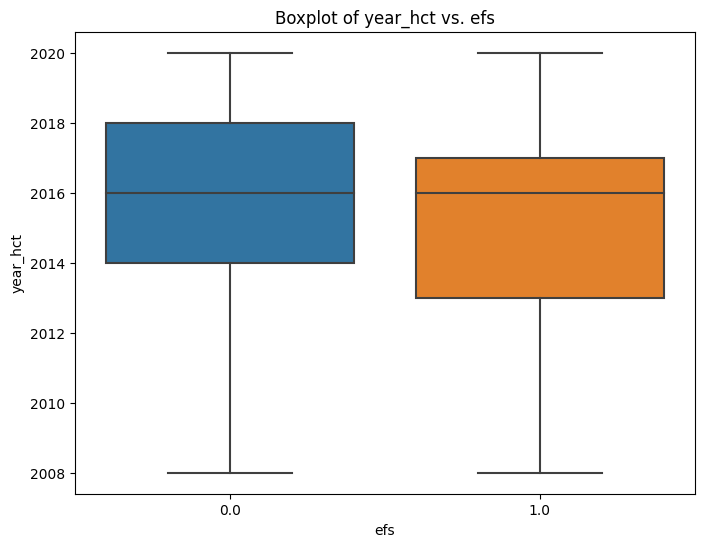

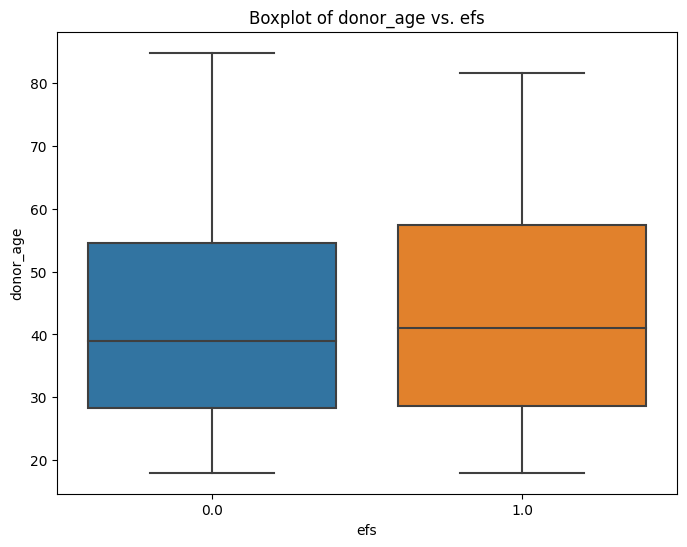

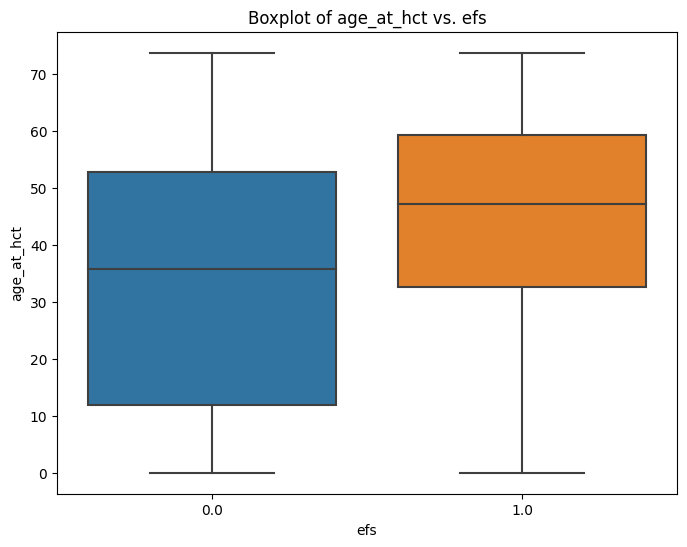

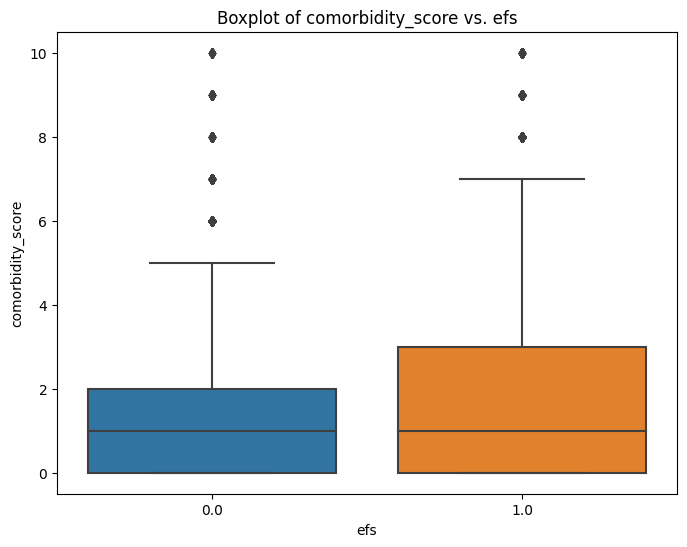

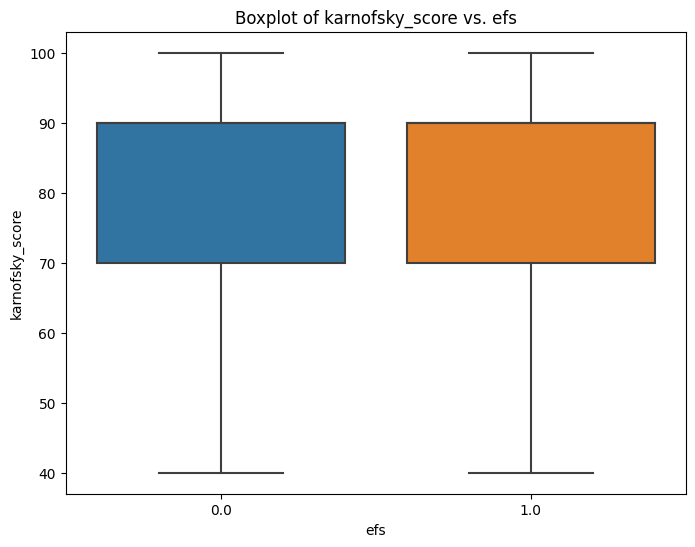

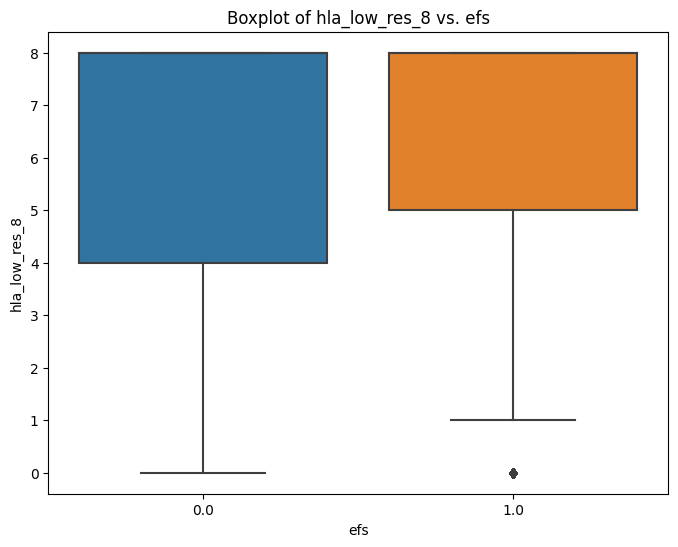

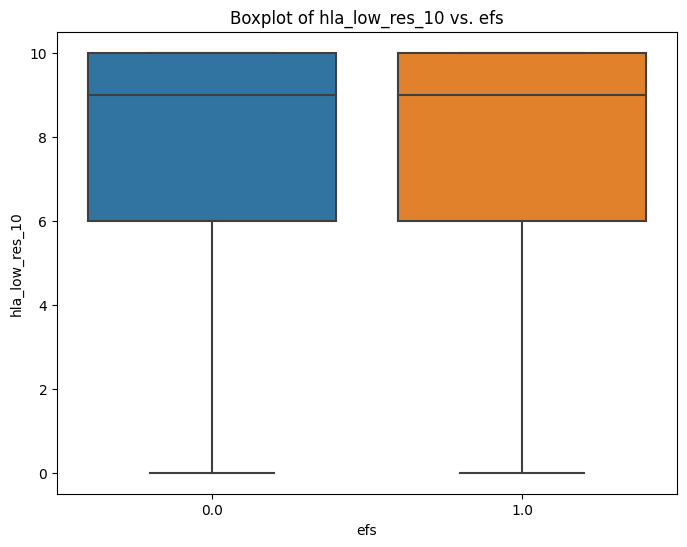

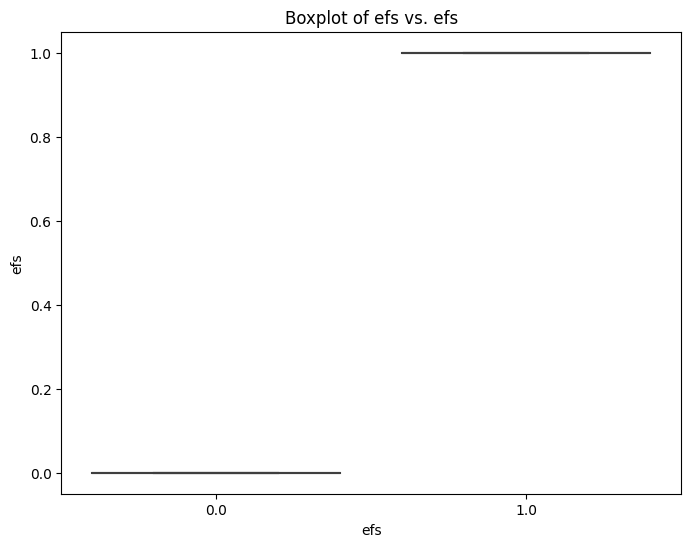

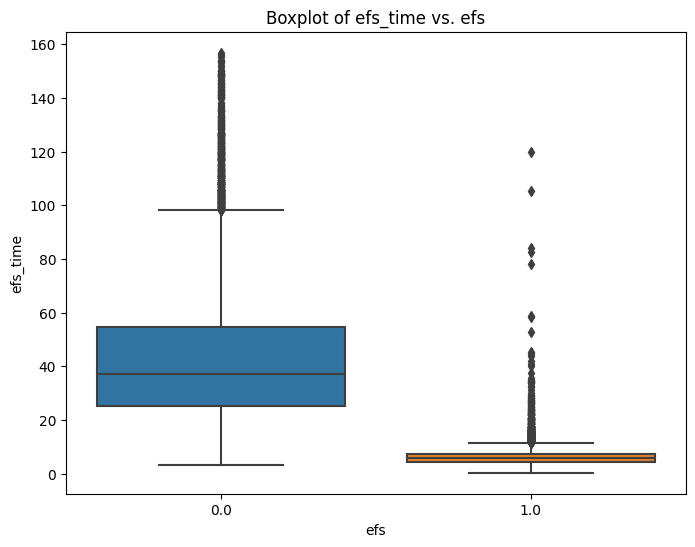

Value counts for dri_score:
dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64


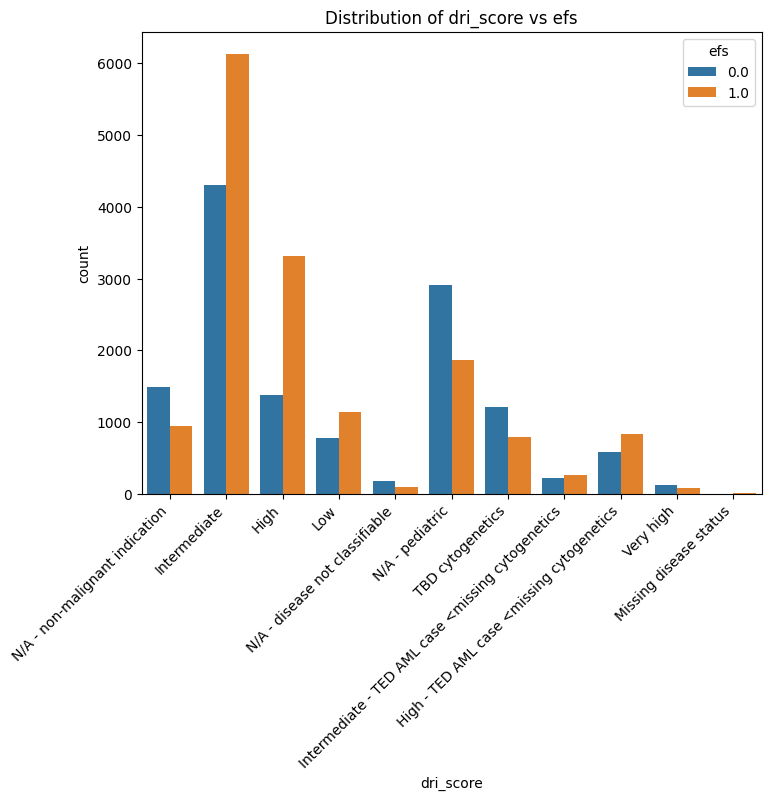

Value counts for psych_disturb:
psych_disturb
No          23005
Yes          3587
Not done      146
Name: count, dtype: int64


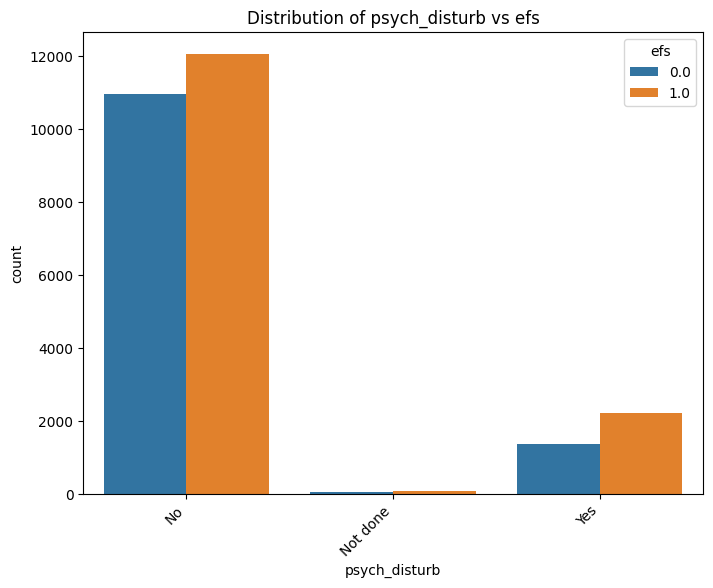

Value counts for cyto_score:
cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
Name: count, dtype: int64


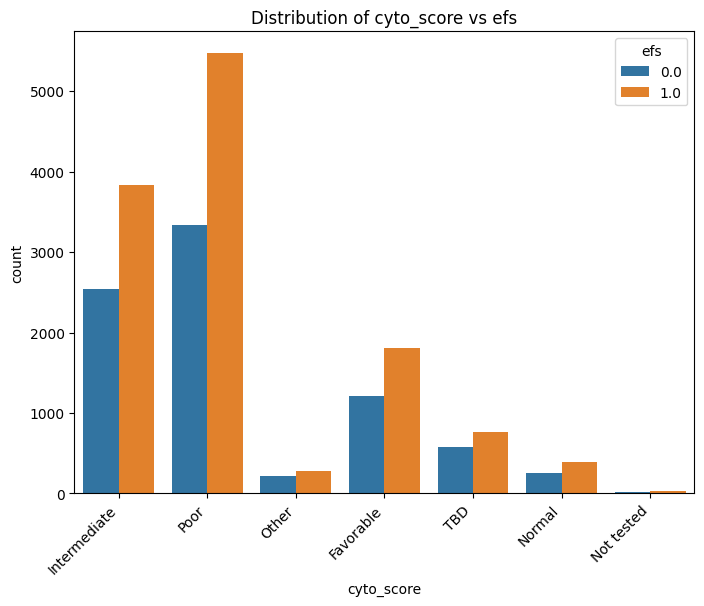

Value counts for diabetes:
diabetes
No          22201
Yes          4339
Not done      141
Name: count, dtype: int64


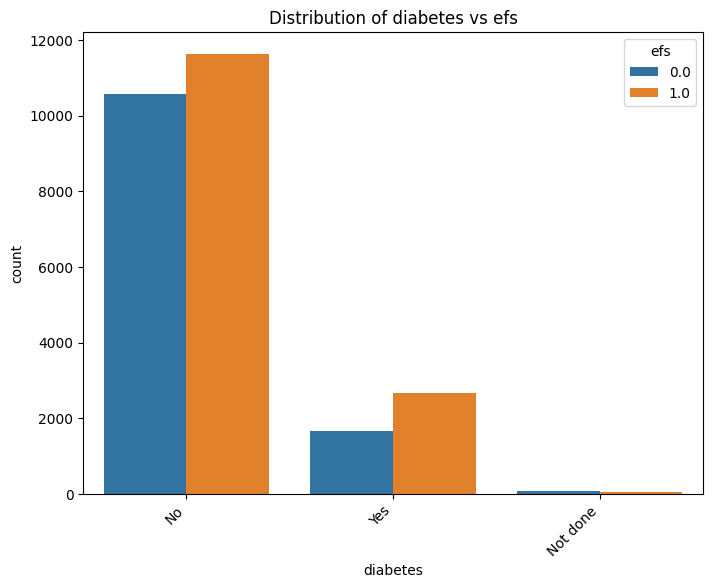

Value counts for tbi_status:
tbi_status
No TBI                              18861
TBI + Cy +- Other                    6104
TBI +- Other, <=cGy                  1727
TBI +- Other, >cGy                   1700
TBI +- Other, -cGy, single            134
TBI +- Other, -cGy, fractionated      119
TBI +- Other, -cGy, unknown dose       79
TBI +- Other, unknown dose             76
Name: count, dtype: int64


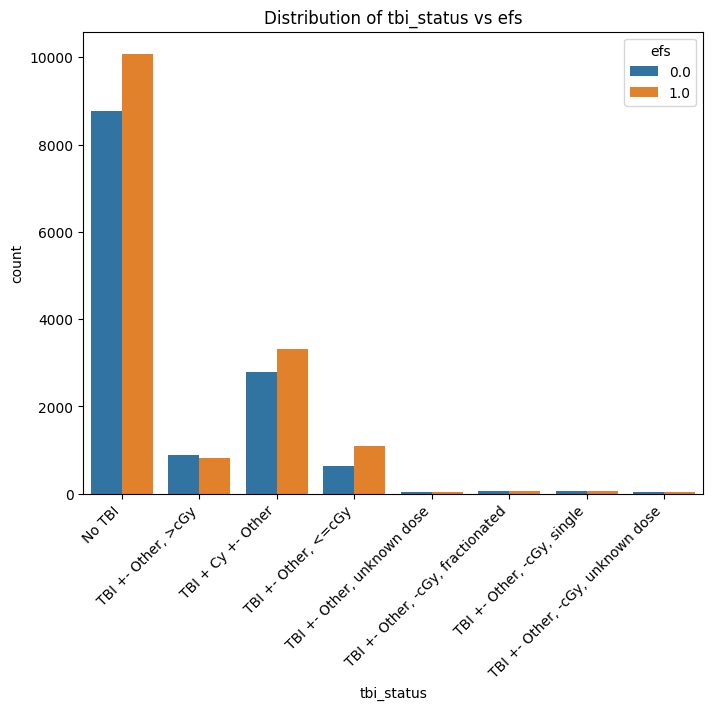

Value counts for arrhythmia:
arrhythmia
No          25203
Yes          1277
Not done      118
Name: count, dtype: int64


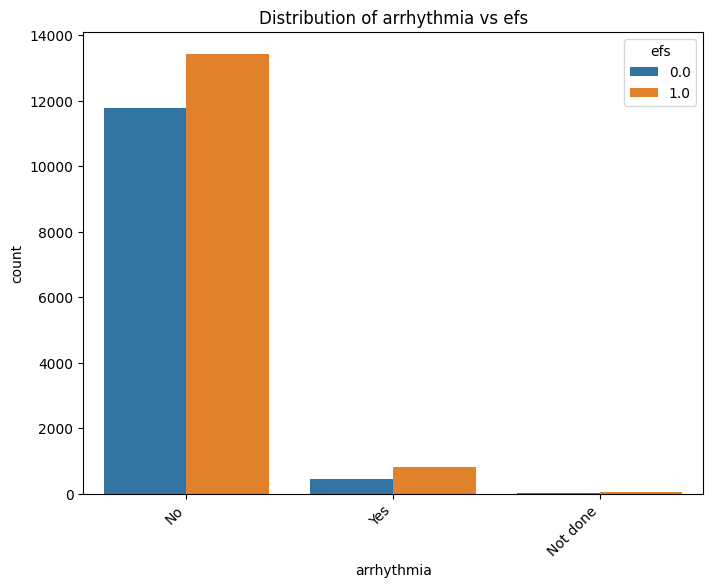

Value counts for graft_type:
graft_type
Peripheral blood    20546
Bone marrow          8254
Name: count, dtype: int64


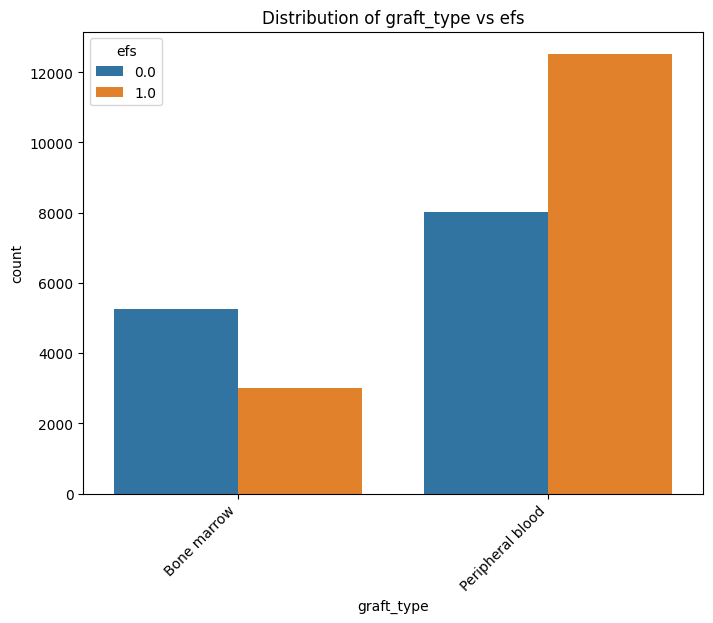

Value counts for vent_hist:
vent_hist
No     27721
Yes      820
Name: count, dtype: int64


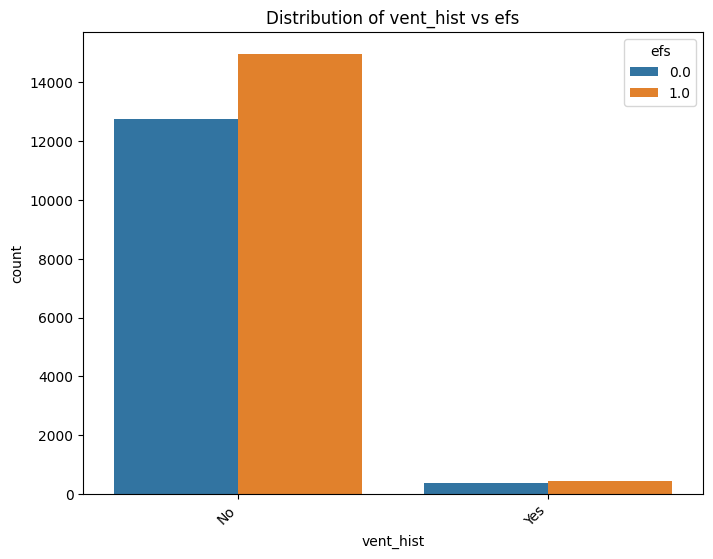

Value counts for renal_issue:
renal_issue
No          26548
Yes           200
Not done      137
Name: count, dtype: int64


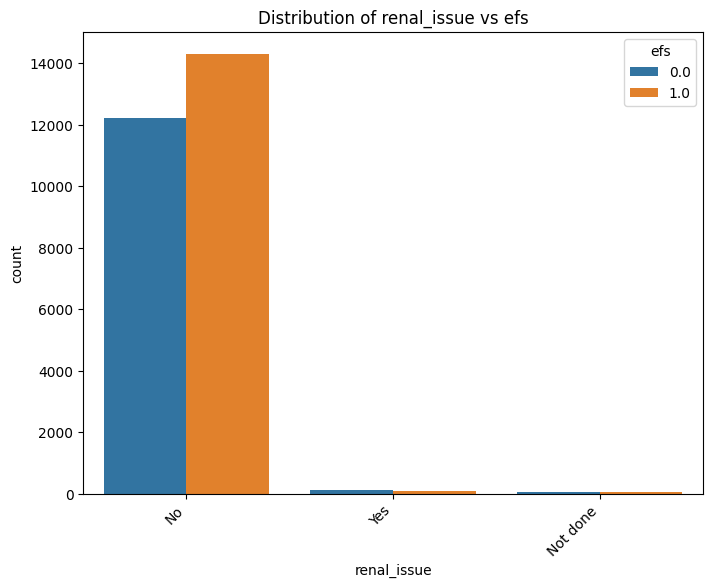

Value counts for pulm_severe:
pulm_severe
No          24779
Yes          1706
Not done      180
Name: count, dtype: int64


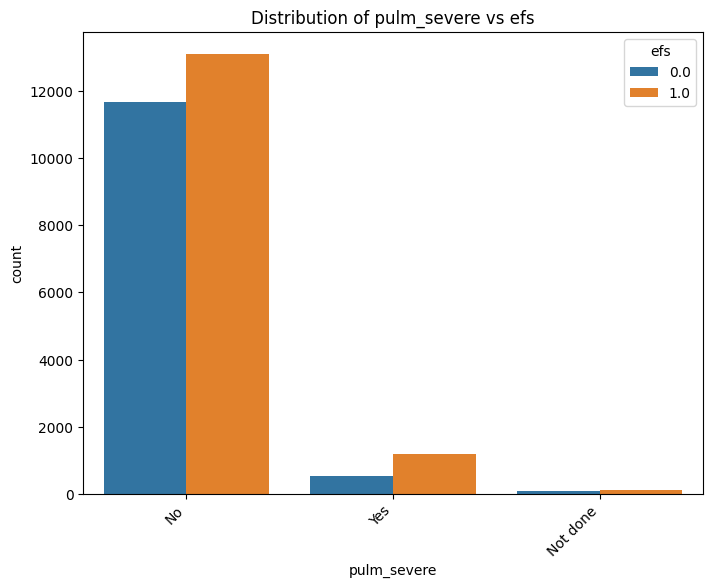

Value counts for prim_disease_hct:
prim_disease_hct
ALL                     8102
AML                     7135
MDS                     3046
IPA                     1719
MPN                     1656
IEA                     1449
NHL                     1319
IIS                     1024
PCD                      869
SAA                      713
AI                       449
HIS                      445
Other leukemia           366
Solid tumor              207
IMD                      144
Other acute leukemia      83
HD                        54
CML                       20
Name: count, dtype: int64


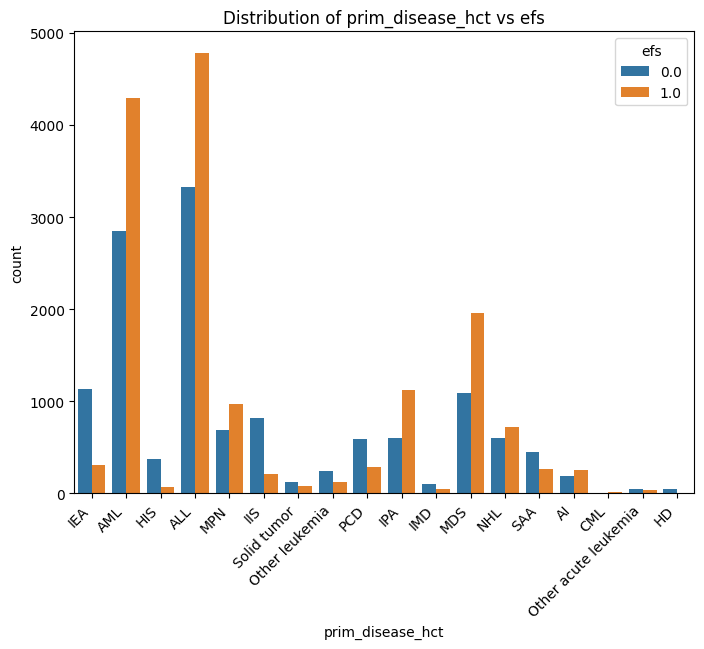

Value counts for cmv_status:
cmv_status
+/+    13596
-/+     7081
+/-     4048
-/-     3441
Name: count, dtype: int64


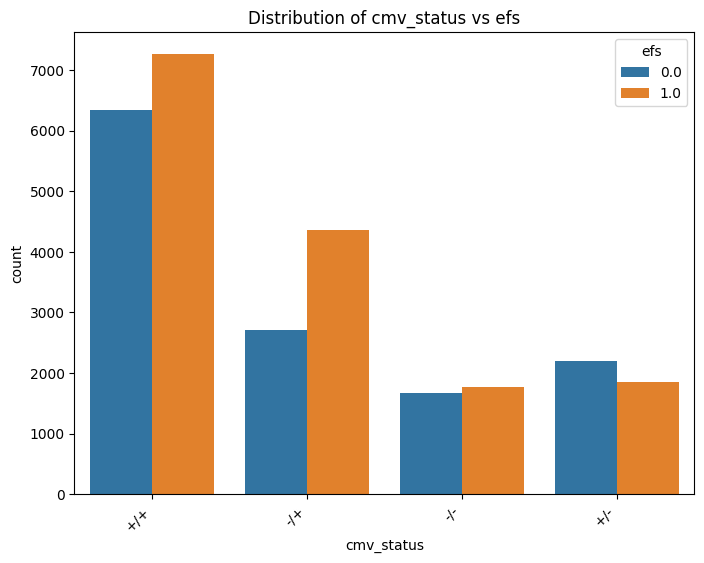

Value counts for tce_imm_match:
tce_imm_match
P/P    13114
G/G     2522
H/H     1084
G/B      544
H/B      229
P/H       83
P/B       66
P/G       25
Name: count, dtype: int64


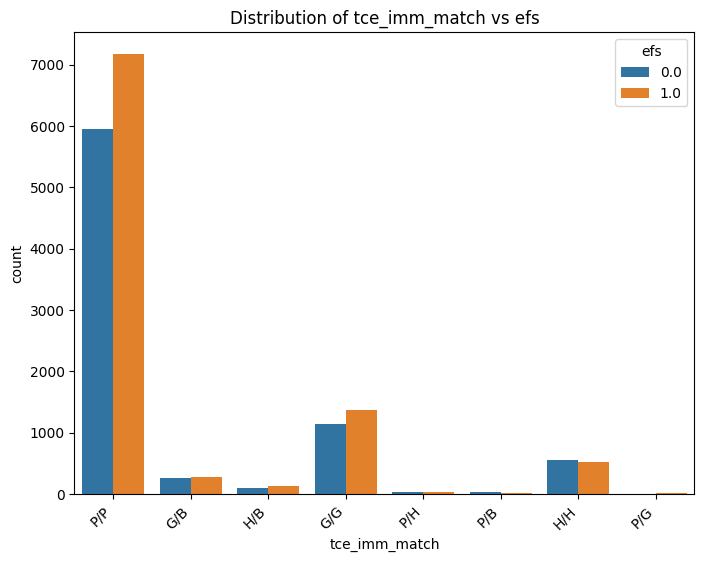

Value counts for rituximab:
rituximab
No     26033
Yes      619
Name: count, dtype: int64


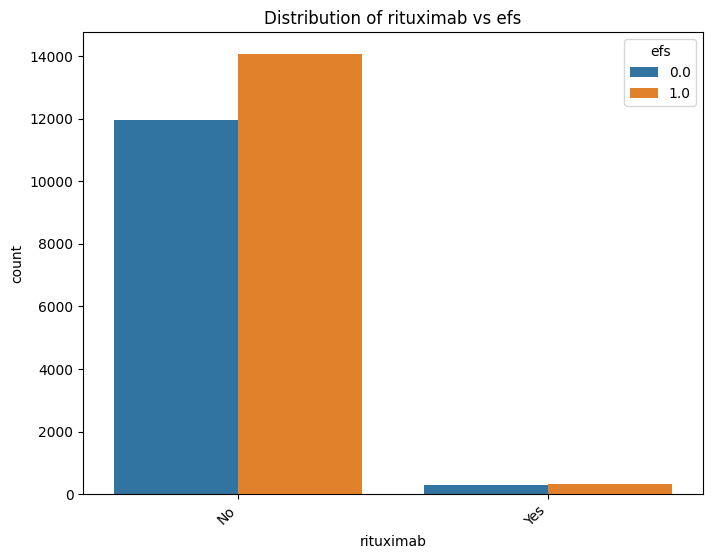

Value counts for prod_type:
prod_type
PB    20381
BM     8419
Name: count, dtype: int64


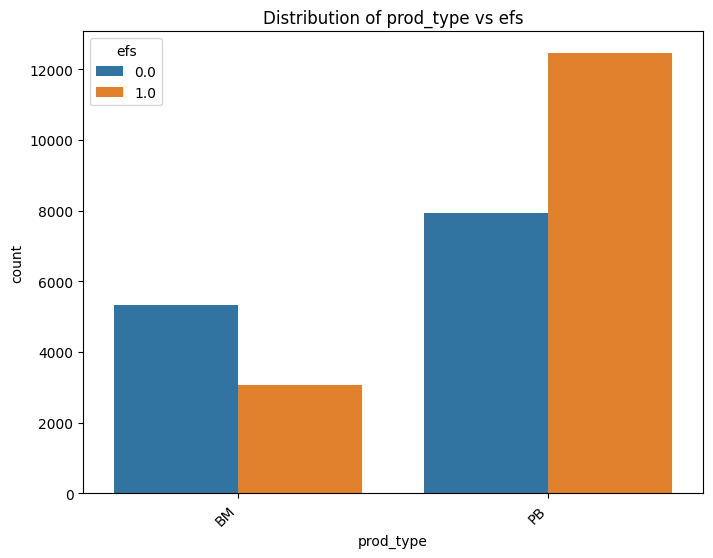

Value counts for cyto_score_detail:
cyto_score_detail
Intermediate    11158
Poor             3323
Favorable        1208
TBD              1043
Not tested        145
Name: count, dtype: int64


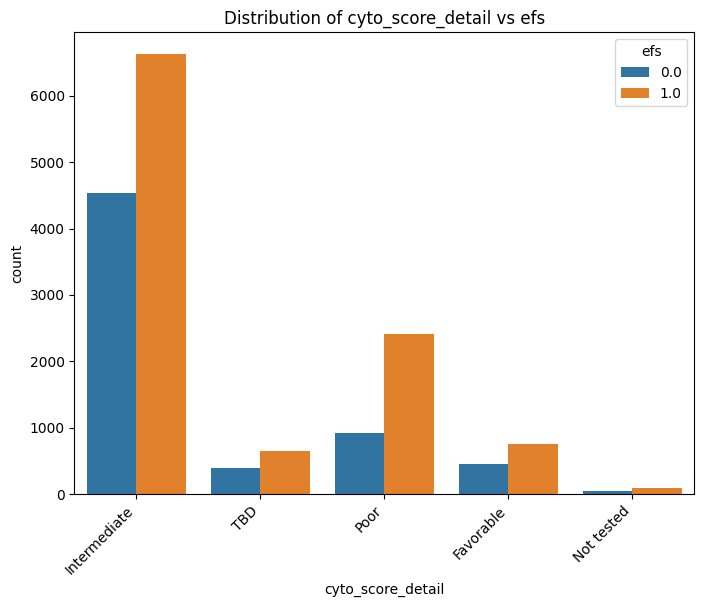

Value counts for conditioning_intensity:
conditioning_intensity
MAC                              12288
RIC                               7722
NMA                               3479
TBD                                373
No drugs reported                   87
N/A, F(pre-TED) not submitted       62
Name: count, dtype: int64


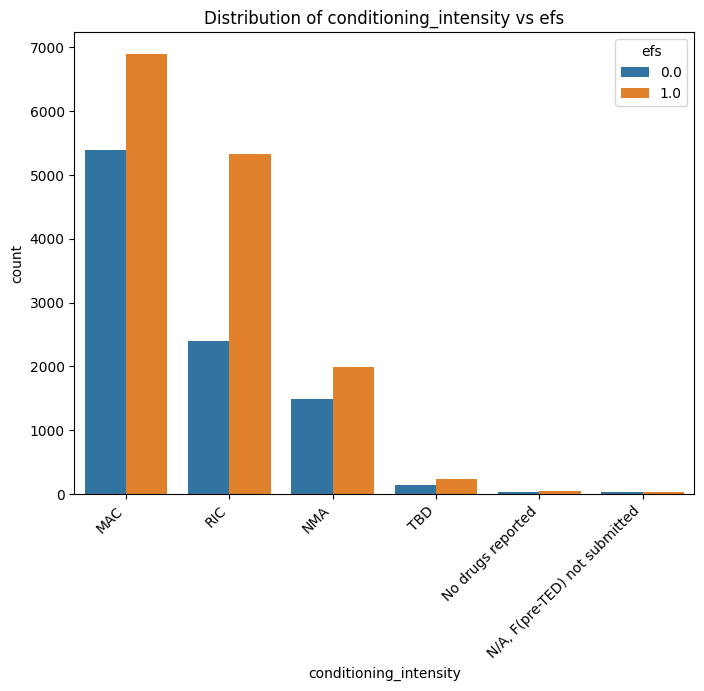

Value counts for ethnicity:
ethnicity
Not Hispanic or Latino      24482
Hispanic or Latino           3347
Non-resident of the U.S.      384
Name: count, dtype: int64


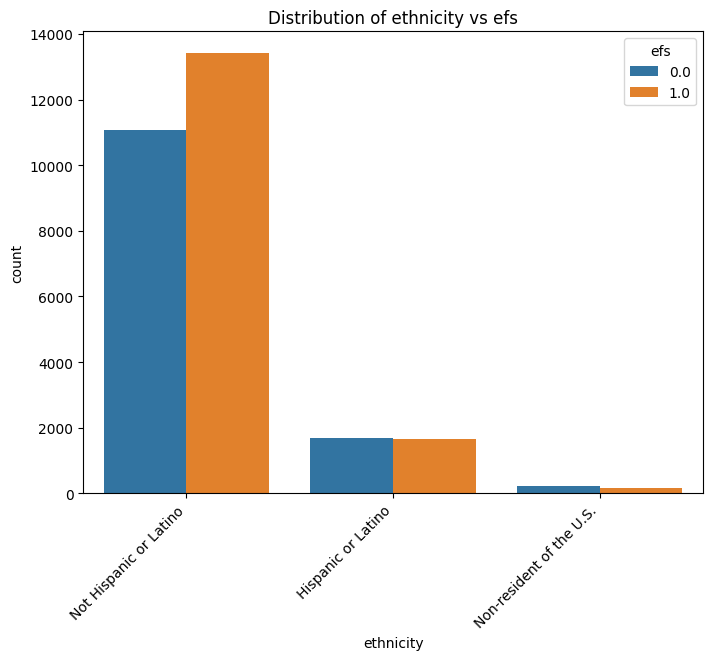

Value counts for obesity:
obesity
No          25144
Yes          1779
Not done      117
Name: count, dtype: int64


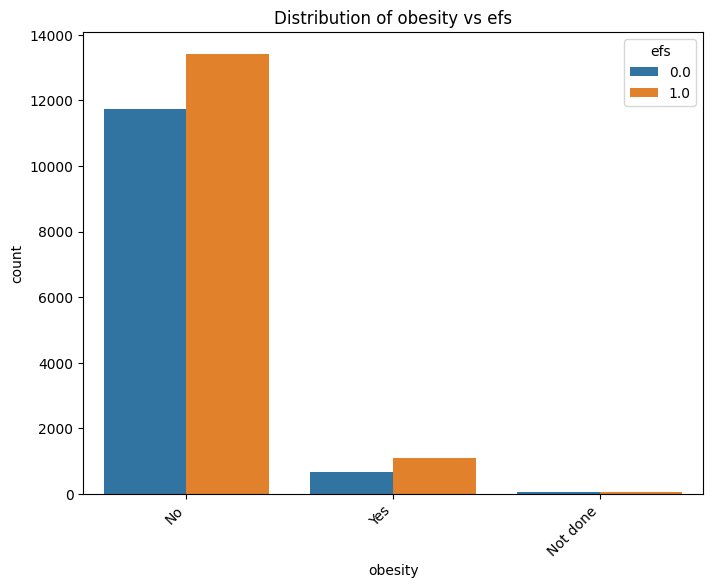

Value counts for in_vivo_tcd:
in_vivo_tcd
No     17591
Yes    10984
Name: count, dtype: int64


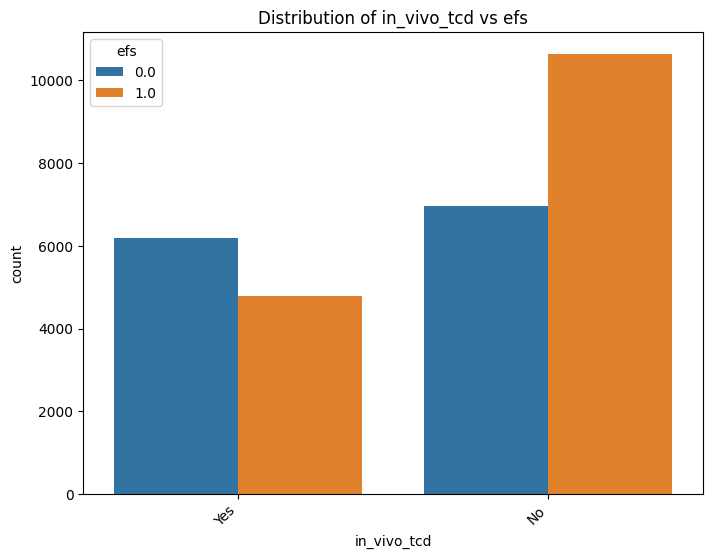

Value counts for hepatic_severe:
hepatic_severe
No          25238
Yes          1481
Not done      210
Name: count, dtype: int64


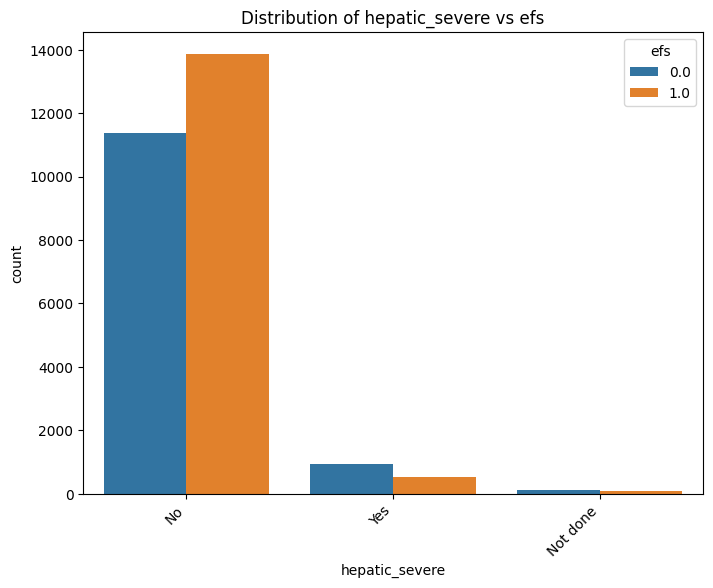

Value counts for prior_tumor:
prior_tumor
No          23828
Yes          3009
Not done      285
Name: count, dtype: int64


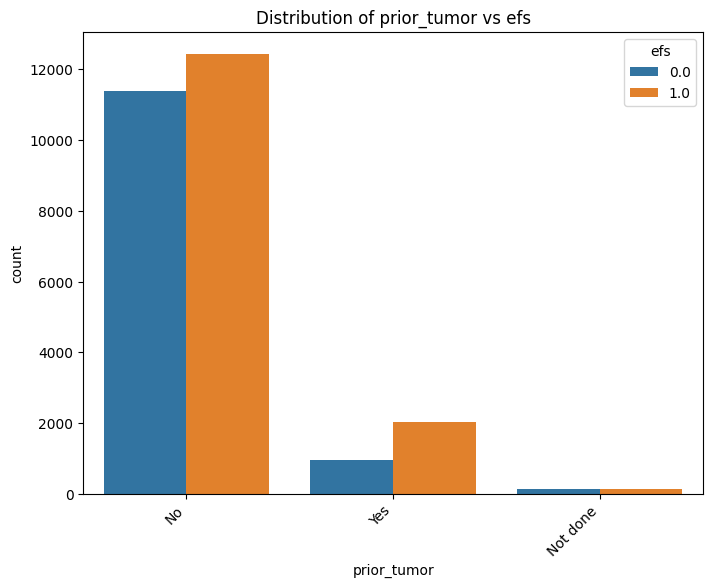

Value counts for peptic_ulcer:
peptic_ulcer
No          25956
Yes           259
Not done      166
Name: count, dtype: int64


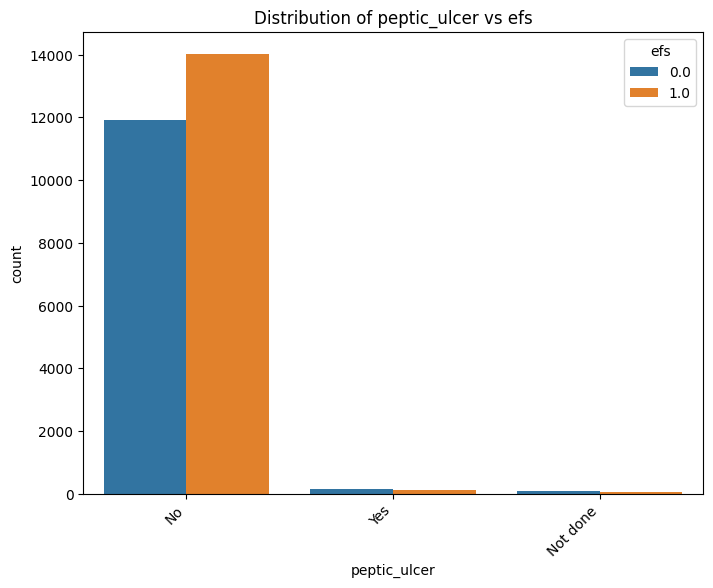

Value counts for gvhd_proph:
gvhd_proph
FK+ MMF +- others                  10440
Cyclophosphamide alone              5270
FK+ MTX +- others(not MMF)          4262
Cyclophosphamide +- others          2369
CSA + MMF +- others(not FK)         2278
FKalone                             1230
Other GVHD Prophylaxis               550
TDEPLETION alone                     545
TDEPLETION +- other                  539
No GvHD Prophylaxis                  262
CDselect alone                       251
CSA + MTX +- others(not MMF,FK)      224
CSA alone                            214
Parent Q = yes, but no agent          62
CDselect +- other                     55
CSA +- others(not FK,MMF,MTX)         23
FK+- others(not MMF,MTX)               1
Name: count, dtype: int64


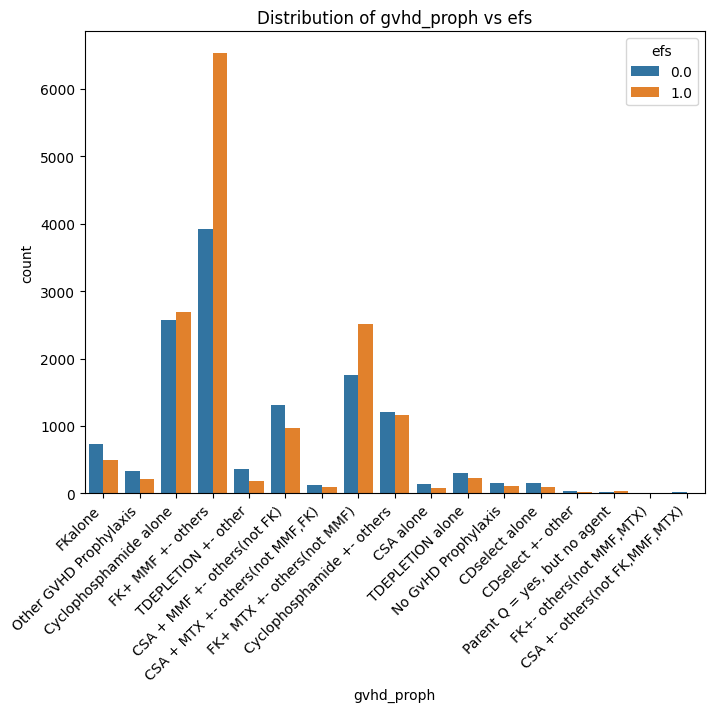

Value counts for rheum_issue:
rheum_issue
No          26015
Yes           457
Not done      145
Name: count, dtype: int64


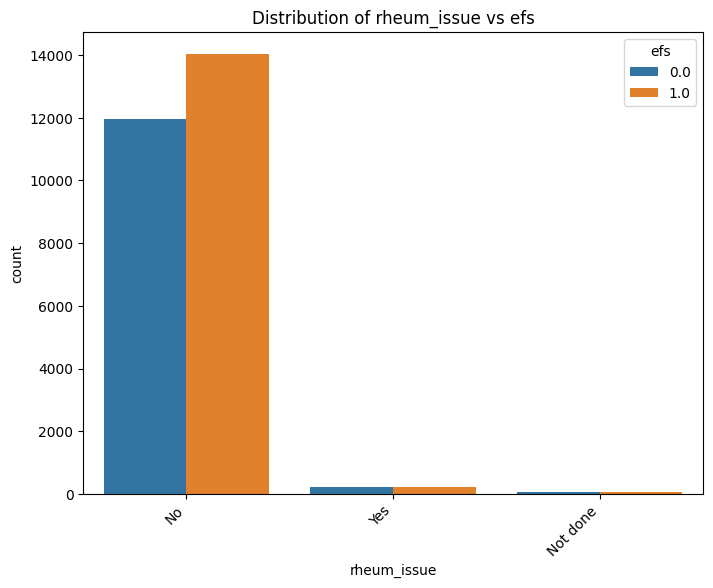

Value counts for sex_match:
sex_match
M-M    7980
F-M    7822
M-F    6715
F-F    6022
Name: count, dtype: int64


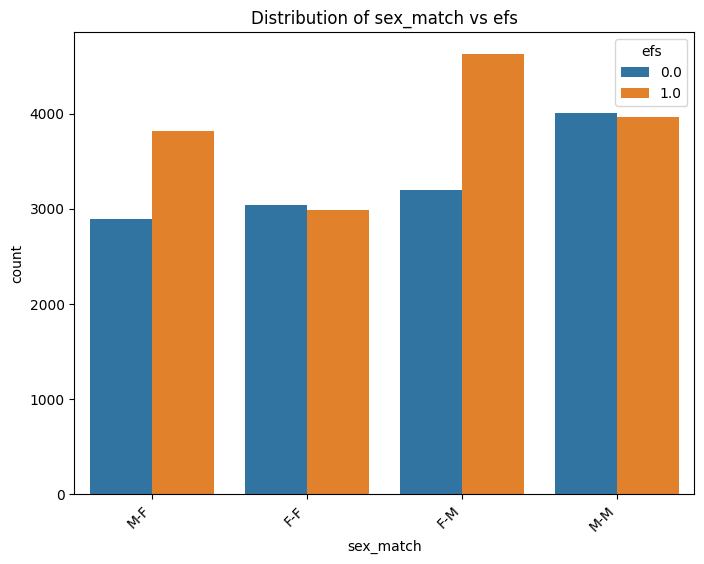

Value counts for race_group:
race_group
More than one race                           4845
Asian                                        4832
White                                        4831
Black or African-American                    4795
American Indian or Alaska Native             4790
Native Hawaiian or other Pacific Islander    4707
Name: count, dtype: int64


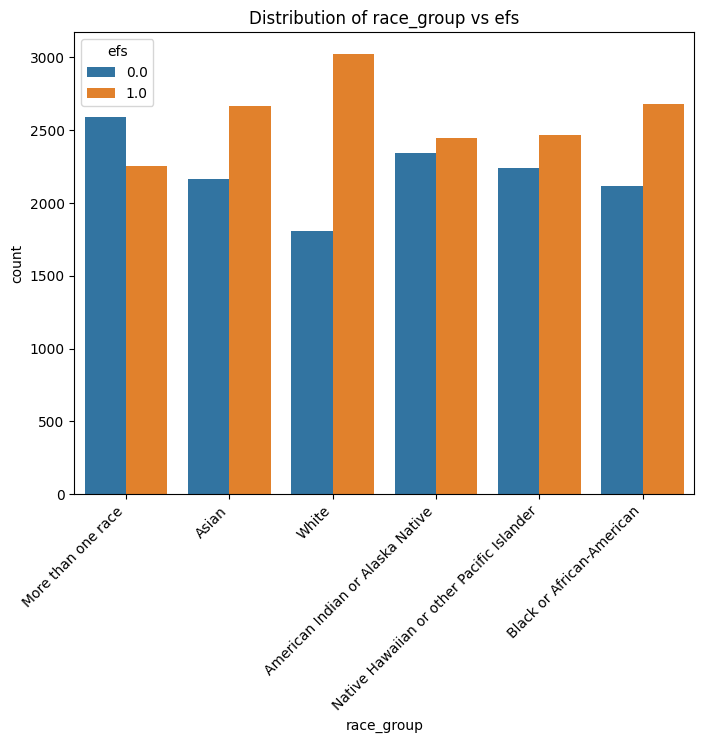

Value counts for hepatic_mild:
hepatic_mild
No          24989
Yes          1754
Not done      140
Name: count, dtype: int64


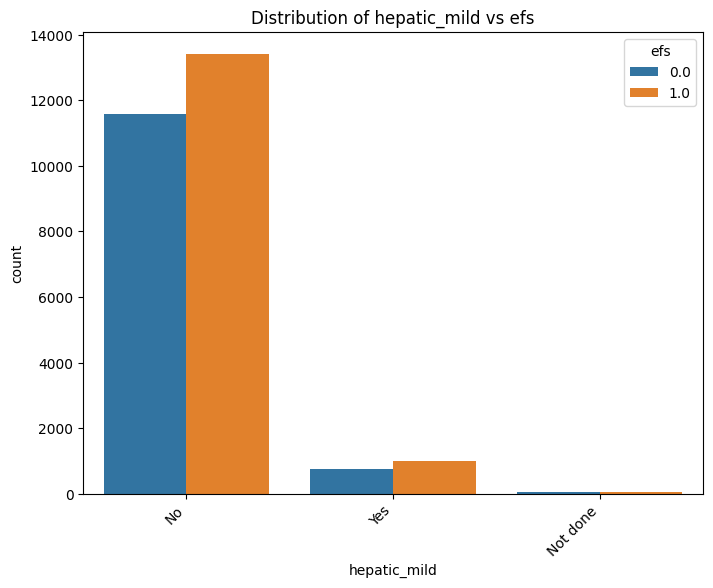

Value counts for tce_div_match:
tce_div_match
Permissive mismatched            12936
GvH non-permissive                2458
HvG non-permissive                1417
Bi-directional non-permissive      593
Name: count, dtype: int64


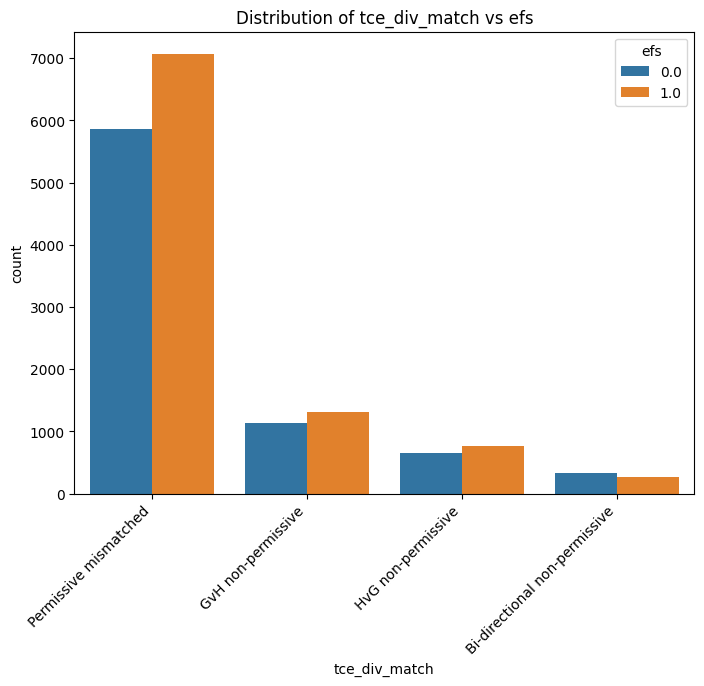

Value counts for donor_related:
donor_related
Related                     16208
Unrelated                   12088
Multiple donor (non-UCB)      346
Name: count, dtype: int64


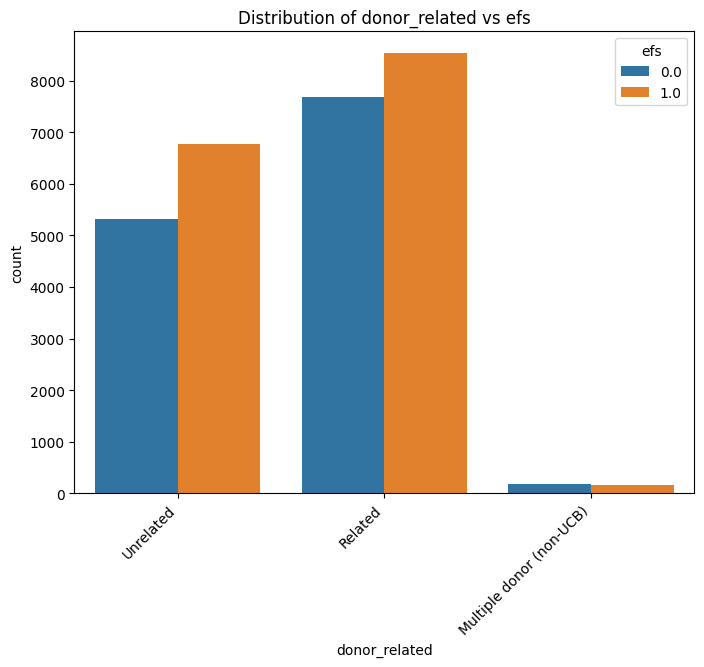

Value counts for melphalan_dose:
melphalan_dose
N/A, Mel not given    20135
MEL                    7260
Name: count, dtype: int64


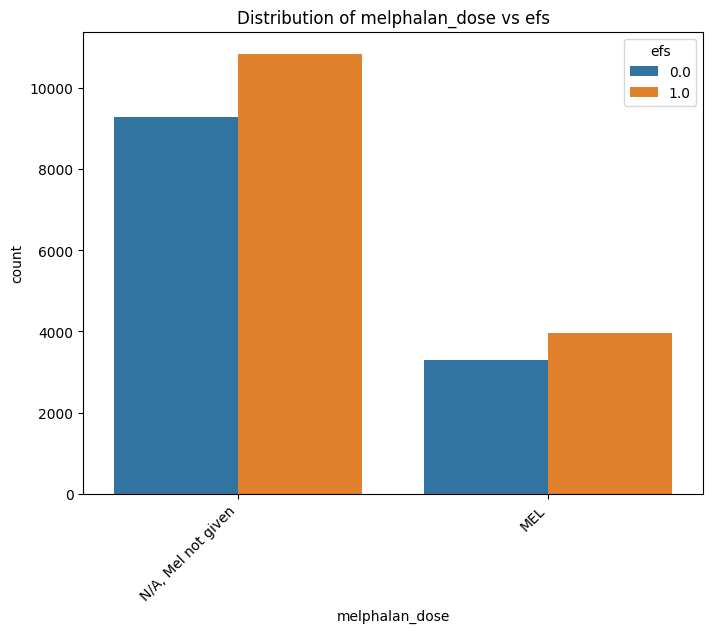

Value counts for cardiac:
cardiac
No          24592
Yes          1519
Not done      147
Name: count, dtype: int64


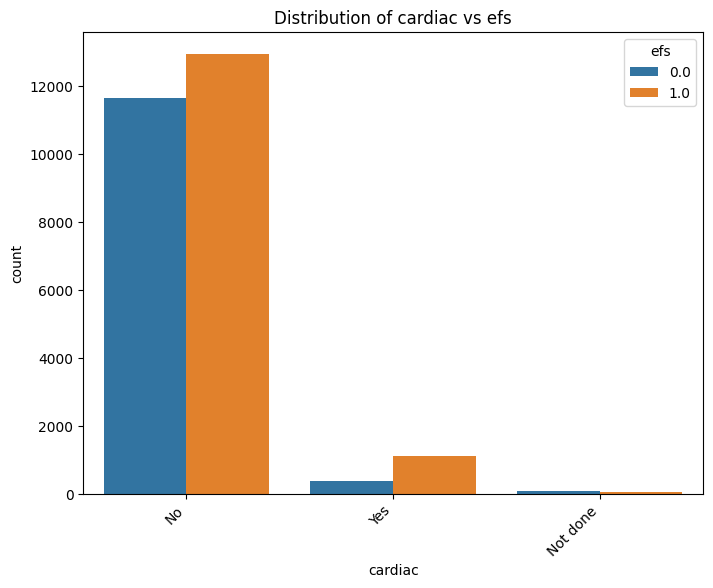

Value counts for pulm_moderate:
pulm_moderate
No          21338
Yes          5249
Not done      166
Name: count, dtype: int64


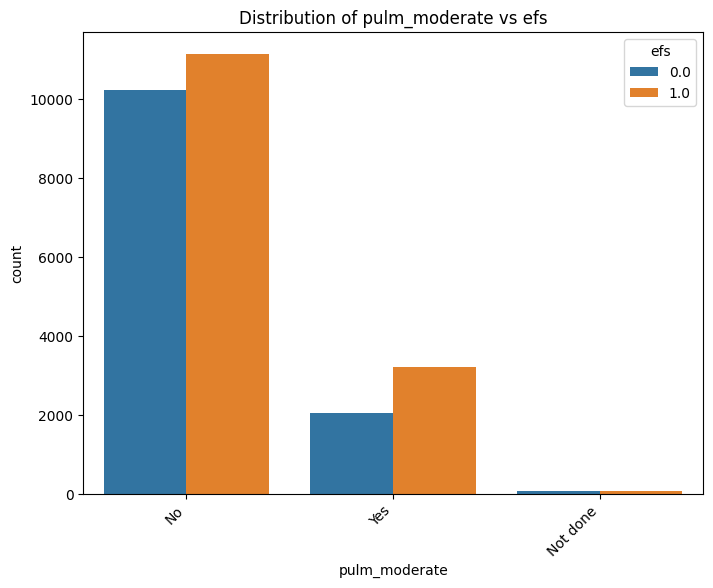

In [14]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='efs', data=train)
plt.title('Distribution of efs (Target Variable)')
plt.show()

# Boxplots for numerical features
numerical_features = train.select_dtypes(include=np.number).columns
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='efs', y=col, data=train)
    plt.title(f'Boxplot of {col} vs. efs')
    plt.show()



categorical_features = train.select_dtypes(exclude=np.number).columns
for col in categorical_features:
  print(f"Value counts for {col}:")
  print(train[col].value_counts())
  plt.figure(figsize=(8, 6))
  sns.countplot(x=col, hue='efs', data=train)
  plt.title(f'Distribution of {col} vs efs')
  plt.xticks(rotation=45, ha='right')
  plt.show()


### To same encoding, combined test and train

In [15]:
# Combine train and test for consistent encoding
combined_df = pd.concat([train, test], axis=0)
combined_encoded = pd.get_dummies(combined_df ,dummy_na=True)

### Fill na values with mice imputation

In [16]:
import re
combined_encoded.columns = [re.sub(r'[!@#$%^&*(){}\[\];:,./<>?\\|`~\=_\']', '_', col) for col in combined_encoded.columns]
mice_kernel = ImputationKernel(
data = combined_encoded.reset_index(drop=True),
random_state = 42
)
mice_kernel.mice(2)
combined_encoded = mice_kernel.complete_data()
combined_encoded.describe()

,ID,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_nmdp_6,year_hct,donor_age,age_at_hct,comorbidity_score,karnofsky_score,hla_low_res_8,hla_low_res_10,efs,efs_time
count,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000,28803.000000
mean,14401.000000,5.897719,4.692011,4.416276,7.321112,4.642572,2015.179356,42.419225,38.662178,1.707183,83.850293,6.278964,7.794501,0.539319,23.235828
std,8314.854238,2.580882,1.769363,1.938368,3.153906,1.773464,3.154117,15.225336,21.147195,1.997589,11.031771,2.327871,2.858870,0.498460,24.799119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,18.010000,0.044000,0.000000,40.000000,0.000000,0.000000,0.000000,0.333000
25%,7200.500000,4.000000,3.000000,3.000000,5.000000,3.000000,2013.000000,28.426500,19.539000,0.000000,70.000000,4.000000,6.000000,0.000000,5.619000
50%,14401.000000,7.000000,6.000000,5.000000,9.000000,6.000000,2016.000000,39.915000,41.005000,1.000000,90.000000,8.000000,9.000000,1.000000,9.793000
75%,21601.500000,8.000000,6.000000,6.000000,10.000000,6.000000,2018.000000,55.966000,55.964500,2.000000,90.000000,8.000000,10.000000,1.000000,35.096500
max,28802.000000,8.000000,6.000000,6.000000,10.000000,6.000000,2020.000000,84.800000,73.726000,10.000000,100.000000,8.000000,10.000000,1.000000,156.819000


In [17]:
# Split back into train and test
train_encoded = combined_encoded.iloc[:len(train)]
test_encoded = combined_encoded.iloc[len(train):]


In [18]:
test_encoded.head()

,ID,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_nmdp_6,year_hct,donor_age,age_at_hct,comorbidity_score,karnofsky_score,hla_low_res_8,hla_low_res_10,efs,efs_time,dri_score_High,dri_score_High - TED AML case _missing cytogenetics,dri_score_Intermediate,dri_score_Intermediate - TED AML case _missing cytogenetics,dri_score_Low,dri_score_Missing disease status,dri_score_N_A - disease not classifiable,dri_score_N_A - non-malignant indication,dri_score_N_A - pediatric,dri_score_TBD cytogenetics,dri_score_Very high,dri_score_nan,psych_disturb_No,psych_disturb_Not done,psych_disturb_Yes,psych_disturb_nan,cyto_score_Favorable,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Not tested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,cyto_score_nan,diabetes_No,diabetes_Not done,diabetes_Yes,diabetes_nan,tbi_status_No TBI,tbi_status_TBI + Cy +- Other,tbi_status_TBI +- Other_ -cGy_ fractionated,tbi_status_TBI +- Other_ -cGy_ single,tbi_status_TBI +- Other_ -cGy_ unknown dose,tbi_status_TBI +- Other_ __cGy,tbi_status_TBI +- Other_ _cGy,tbi_status_TBI +- Other_ unknown dose,tbi_status_nan,arrhythmia_No,arrhythmia_Not done,arrhythmia_Yes,arrhythmia_nan,graft_type_Bone marrow,graft_type_Peripheral blood,graft_type_nan,vent_hist_No,vent_hist_Yes,vent_hist_nan,renal_issue_No,renal_issue_Not done,renal_issue_Yes,renal_issue_nan,pulm_severe_No,pulm_severe_Not done,pulm_severe_Yes,pulm_severe_nan,prim_disease_hct_AI,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Other acute leukemia,prim_disease_hct_Other leukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solid tumor,prim_disease_hct_nan,cmv_status_+_+,cmv_status_+_-,cmv_status_-_+,cmv_status_-_-,cmv_status_nan,tce_imm_match_G_B,tce_imm_match_G_G,tce_imm_match_H_B,tce_imm_match_H_H,tce_imm_match_P_B,tce_imm_match_P_G,tce_imm_match_P_H,tce_imm_match_P_P,tce_imm_match_nan,rituximab_No,rituximab_Yes,rituximab_nan,prod_type_BM,prod_type_PB,prod_type_nan,cyto_score_detail_Favorable,cyto_score_detail_Intermediate,cyto_score_detail_Not tested,cyto_score_detail_Poor,cyto_score_detail_TBD,cyto_score_detail_nan,conditioning_intensity_MAC,conditioning_intensity_N_A_ F_pre-TED_ not submitted,conditioning_intensity_NMA,conditioning_intensity_No drugs reported,conditioning_intensity_RIC,conditioning_intensity_TBD,conditioning_intensity_nan,ethnicity_Hispanic or Latino,ethnicity_Non-resident of the U_S_,ethnicity_Not Hispanic or Latino,ethnicity_nan,obesity_No,obesity_Not done,obesity_Yes,obesity_nan,in_vivo_tcd_No,in_vivo_tcd_Yes,in_vivo_tcd_nan,hepatic_severe_No,hepatic_severe_Not done,hepatic_severe_Yes,hepatic_severe_nan,prior_tumor_No,prior_tumor_Not done,prior_tumor_Yes,prior_tumor_nan,peptic_ulcer_No,peptic_ulcer_Not done,peptic_ulcer_Yes,peptic_ulcer_nan,gvhd_proph_CDselect +- other,gvhd_proph_CDselect alone,gvhd_proph_CSA + MMF +- others_not FK_,gvhd_proph_CSA + MTX +- others_not MMF_FK_,gvhd_proph_CSA +- others_not FK_MMF_MTX_,gvhd_proph_CSA alone,gvhd_proph_Cyclophosphamide +- others,gvhd_proph_Cyclophosphamide alone,gvhd_proph_FK+ MMF +- others,gvhd_proph_FK+ MTX +- others_not MMF_,gvhd_proph_FK+- others_not MMF_MTX_,gvhd_proph_FKalone,gvhd_proph_No GvHD Prophylaxis,gvhd_proph_Other GVHD Prophylaxis,gvhd_proph_Parent Q _ yes_ but no agent,gvhd_proph_TDEPLETION +- other,gvhd_proph_TDEPLETION alone,gvhd_proph_nan,rheum_issue_No,rheum_issue_Not done,rheum_issue_Yes,rheum_issue_nan,sex_match_F-F,sex_match_F-M,sex_match_M-F,sex_match_M-M,sex_match_nan,race_group_American Indian or Alaska Native,race_group_Asian,race_group_Black or African-American,race_group_More than one race,race_group_Native Hawaiian or other Pacific Islander,race_group_White,race_group_nan,hepatic_mild_No,hepatic_mild_Not done,hepatic_mild_Yes,hepatic_mild_nan,tce_div_match_Bi-di

<Axes: xlabel='efs_time'>

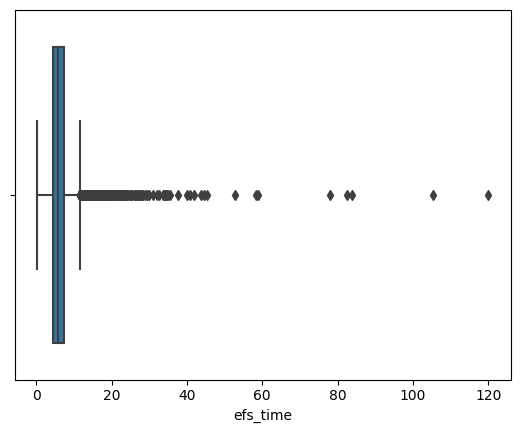

In [19]:
sns.boxplot(data= train_encoded[train_encoded['efs']==1], x='efs_time')

<Axes: xlabel='efs_time'>

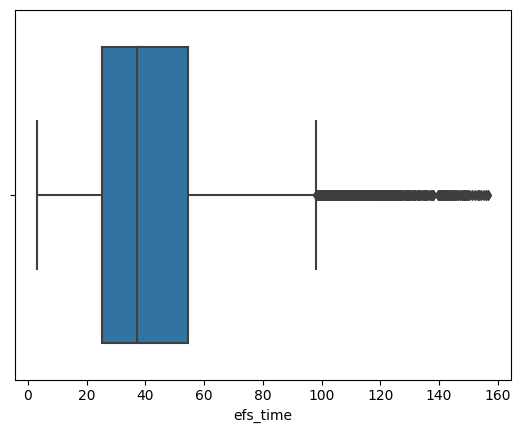

In [20]:
sns.boxplot(data= train_encoded[train_encoded['efs']==0], x='efs_time')


In [21]:
upper_limit = train_encoded['efs_time'].mean() + 3*train_encoded['efs_time'].std()
lower_limit = train_encoded['efs_time'].mean() - 3*train_encoded['efs_time'].std()

df_train_clean = train_encoded.loc[(train_encoded['efs_time'] <= upper_limit) & (train_encoded['efs_time'] >= lower_limit)]

df_train_original = train_encoded
df_train = df_train_clean
df_train.reset_index(drop=True, inplace=True)

<Axes: xlabel='efs_time'>

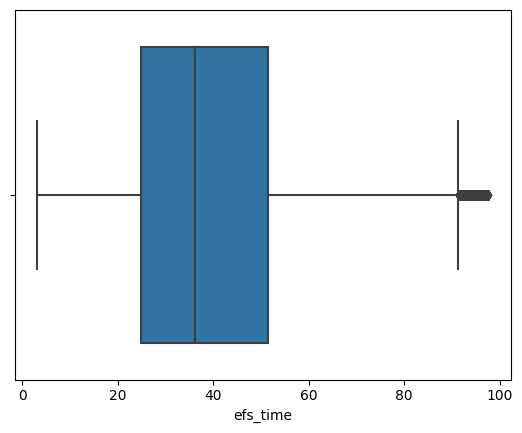

In [22]:
sns.boxplot(data= df_train_clean[df_train_clean['efs']==0], x='efs_time')


In [23]:
print(f'Training data shape : {df_train.shape}')
print(f'Test data shape : {test_encoded.shape}')

Training data shape : (28286, 203)
Test data shape : (3, 203)


### Train models

#### LightGBM

In [24]:
T=df_train['efs_time']
E=df_train['efs']
X=df_train.drop(['efs','efs_time','ID'],axis=1)
X_test=test_encoded.drop(['efs','efs_time',"ID"],axis=1)

In [25]:
# Robust scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prediction storage
test_predictions = np.zeros(len(X_test))

# Advanced LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'dart',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'verbosity': -1
}

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, E), 1):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    T_train, T_val = T.iloc[train_idx], T.iloc[val_idx]
    E_train, E_val = E.iloc[train_idx], E.iloc[val_idx]

    train_data = lgb.Dataset(
        X_train,
        label=-T_train,
        weight=E_train
    )

    val_data = lgb.Dataset(
        X_val,
        label=-T_val,
        weight=E_val
    )

    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
    )
    #print metrics
    print(f'Fold {fold} - MAE: {model.best_score["valid_1"]["l1"]}')
    # Predict test data
    test_predictions += model.predict(X_test_scaled) / 5

Fold 1 - MAE: 1.6592154954560732
Fold 2 - MAE: 1.61721035886762
Fold 3 - MAE: 1.6709152350803205
Fold 4 - MAE: 1.688205894207177
Fold 5 - MAE: 1.6666181907799038


In [26]:
predictions= test_predictions

In [27]:
# Create submission with normalization
submission = pd.DataFrame({
    'ID': test_encoded["ID"],
    'prediction': (predictions - predictions.min()) / (predictions.max() - predictions.min())
})

# Save submission
submission.to_csv('submission_lgb.csv', index=False)

In [28]:
print("Submission Preview:")
print(submission.head())
print("\nPrediction Statistics:")
print(submission['prediction'].describe())

Submission Preview:
          ID  prediction
28800  28800    1.000000
28801  28801    0.000000
28802  28802    0.600576

Prediction Statistics:
count    3.000000
mean     0.533525
std      0.503361
min      0.000000
25%      0.300288
50%      0.600576
75%      0.800288
max      1.000000
Name: prediction, dtype: float64


### Model Training Approach

In this step, the data is divided and processed in various ways, and the LightGBM model is tuned with specific parameters for prediction.

1. **Feature Scaling (Robust Scaling)**:  
   To ensure that the features are on a comparable scale and to reduce the impact of outliers, **RobustScaler** is used for scaling the data. This method scales the data using the median and interquartile range, making it robust to outliers.

2. **Data Splitting using Stratified K-Fold**:  
   **Stratified K-Fold** is used to split the data into 5 folds. This ensures that each fold contains a proportional representation of the target variable (`efs`). This approach helps in providing more reliable and balanced splits of the data.

3. **LightGBM Model Parameters**:  
   The LightGBM model is configured for regression and tuned with the following parameters:
   - **Objective**: The model is set to perform a regression task.
   - **Evaluation Metric**: **Mean Absolute Error (MAE)** is used as the evaluation metric for model performance.
   - **Boosting Type**: **dart** boosting is used, which employs dropout to prevent overfitting.
   - Additional parameters such as **learning_rate**, **num_leaves**, **max_depth**, and regularization terms are adjusted to optimize model performance.

4. **Model Training with Cross-Validation**:  
   In each fold of cross-validation, the data is split into training and validation sets. The model is trained on the training set and validated on the validation set. The weight of each sample is determined by the `E_train` column.

5. **Prediction and Averaging Results**:  
   After training the model in each fold, predictions are made on the test data, and the results are averaged across all five folds to obtain a more stable and reliable final prediction.

6. **Model Evaluation**:  
   The **Mean Absolute Error (MAE)** is calculated and printed for each fold, providing continuous feedback on model performance during training.

This approach ensures that the model is trained optimally and evaluated with a higher degree of accuracy.


#### XGBoost

In [29]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(X))
pred_efs = np.zeros(len(test_encoded))

for i, (train_index, test_index) in enumerate(kf.split(X, E)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = X.iloc[train_index]  # Changed line: Using .iloc to select rows by index
    y_train = E.iloc[train_index] # Changed line: Using .iloc to select rows by index "efs"]
    x_valid = X.iloc[test_index]  # Changed line: Using .iloc to select rows by index
    y_valid = E.iloc[test_index] # Changed line: Using .iloc to select rows by index "efs"]
    x_test = test_encoded.drop(['efs','efs_time',"ID"],axis=1)

    model_xgb = XGBClassifier(
        device="cuda",
        max_depth=3,
        colsample_bytree=0.7129400756425178,
        subsample=0.8185881823156917,
        n_estimators=20_000,
        learning_rate=0.04425768131771064,
        eval_metric="auc",
        early_stopping_rounds=50,
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)


#########################
### Fold 1
#########################
[0]	validation_0-auc:0.66603


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:18:57] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.73875
[200]	validation_0-auc:0.74910
[300]	validation_0-auc:0.75326
[400]	validation_0-auc:0.75550
[500]	validation_0-auc:0.75701
[600]	validation_0-auc:0.75753
[642]	validation_0-auc:0.75746
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67166


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:19:06] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.74459
[200]	validation_0-auc:0.75507
[300]	validation_0-auc:0.75938
[400]	validation_0-auc:0.76114
[500]	validation_0-auc:0.76285
[600]	validation_0-auc:0.76391
[700]	validation_0-auc:0.76412
[722]	validation_0-auc:0.76410
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67693


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:19:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.74331
[200]	validation_0-auc:0.75083
[300]	validation_0-auc:0.75352
[400]	validation_0-auc:0.75506
[500]	validation_0-auc:0.75573
[598]	validation_0-auc:0.75587
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.67331


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:19:27] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.75261
[200]	validation_0-auc:0.75995
[300]	validation_0-auc:0.76085
[371]	validation_0-auc:0.76086
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.67207


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:19:33] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.74554
[200]	validation_0-auc:0.75291
[300]	validation_0-auc:0.75621
[400]	validation_0-auc:0.75791
[500]	validation_0-auc:0.75972
[600]	validation_0-auc:0.76033
[700]	validation_0-auc:0.76114
[751]	validation_0-auc:0.76097


In [30]:
# EVALUATE PERFORMANCE
accuracy = accuracy_score(E, oof_xgb)
f1 = f1_score(E, oof_xgb)
roc_auc = roc_auc_score(E, oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 0.6785
F1 Score: 0.7533
ROC AUC Score: 0.6551


#### Model Training and Evaluation with XGBoost

In this section, we use the XGBoost classifier with Stratified K-Fold cross-validation to evaluate the model's performance and make predictions on the test set.

1. **Stratified K-Fold Cross-Validation**:  
   To ensure the data is divided into balanced training and validation sets, **Stratified K-Fold** is applied. This method splits the data into 5 folds, ensuring that each fold maintains the proportion of the target variable (`efs`). This helps to avoid imbalanced splits, which could lead to biased results. The cross-validation process is repeated for each fold to assess the model’s generalization ability.

2. **Model Configuration (XGBoost Classifier)**:  
   We configure the **XGBoost classifier** with the following parameters to tune the model for better performance:
   - **Max Depth**: Limits the maximum depth of each tree to avoid overfitting.
   - **Colsample_bytree**: Specifies the fraction of features to consider for each tree, helping to prevent overfitting by introducing randomness.
   - **Subsample**: Defines the fraction of samples to use for each boosting iteration.
   - **Learning Rate**: The rate at which the model learns, adjusted for better convergence.
   - **Eval Metric**: The evaluation metric is set to **AUC** (Area Under Curve) to measure model performance on binary classification.
   - **Early Stopping**: Training stops if validation performance doesn't improve for 50 rounds, helping to prevent overfitting.
   - **Scale Pos Weight**: Adjusted to handle class imbalance, giving more weight to the minority class.

3. **Training and Validation**:  
   For each fold, the training and validation sets are created by splitting the data based on the fold indices. The XGBoost model is trained on the training data and evaluated on the validation data. The predictions on the validation set are then used to compute the out-of-fold (OOF) predictions, which are stored for further performance evaluation.

4. **Predictions on the Test Set**:  
   After training on each fold, the model is used to predict probabilities for the test set (`test_encoded`). The probabilities for the positive class are averaged across all folds, and then converted into binary predictions (0 or 1) based on a threshold of 0.5.

5. **Out-of-Fold Predictions**:  
   The OOF predictions are derived from the validation sets of each fold. These predictions are stored in `oof_xgb` and represent the model's predictions on data that it hasn't seen during training.

6. **Final Test Predictions**:  
   After averaging the predicted probabilities for all folds, the final test predictions are computed by applying a threshold of 0.5. This converts the average probabilities into binary predictions (`0` or `1`), which are stored in `pred_efs`.

7. **Model Evaluation**:  
   To assess the performance of the model, the **accuracy** and **F1 score** can be computed on the out-of-fold predictions (`oof_xgb`). Additionally, **ROC AUC** can be calculated to measure the model’s performance in distinguishing between the classes.

This approach ensures that the model is evaluated robustly, with predictions averaged across multiple folds to reduce variance and improve generalization.


### Target Transformation

In this step, the target variable (`y`) is transformed based on both the **`efs`** (event status) and **`efs_time`** (time-related feature). The transformation adjusts the target to account for the two classes (survived and not survived) and prepares it for model training.

1. **Target Transformation**:  
   A new target variable, `y`, is created by initially copying the values of **`efs_time`**. The transformation proceeds as follows:
   - **For `efs = 1` (Did Not Survive)**: The maximum value of **`efs_time`** for this class is computed (`mx`).
   - **For `efs = 0` (Maybe Survived)**: The minimum value of **`efs_time`** for this class is computed (`mn`).
   - The target variable for `efs = 0` is then adjusted by adding the difference between the maximum (`mx`) and minimum (`mn`) values, ensuring that the two classes have a more comparable scale.

2. **Ranking and Scaling**:  
   After transforming the target variable, it is ranked, and the values are normalized to a range between 0 and 1 by dividing by the maximum rank. Additionally, for the `efs = 0` class, the target variable is shifted by half the length of the dataset to avoid overlap between the classes.



<ipython-input-31-ac24018440a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["y"] = train.efs_time.values
<ipython-input-31-ac24018440a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.y = train.y.rank()
<ipython-input-31-ac24018440a5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

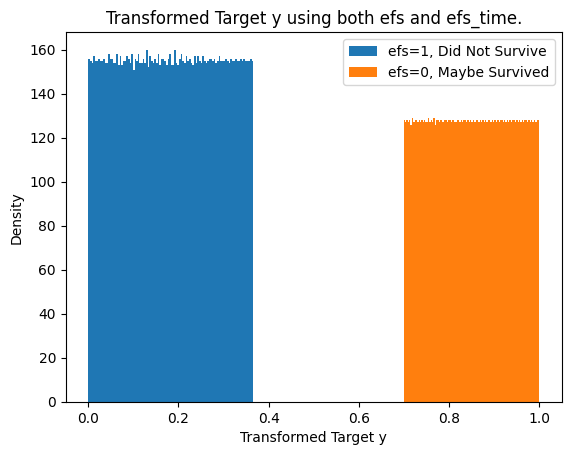

In [31]:
train=df_train
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += len(train)//2
train.y = train.y / train.y.max()

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

 **Plot Interpretation**:  
   The plot provides a clear view of how the transformed target variable (`y`) is distributed for each class. The density of the transformed target for **`efs = 1` (Did Not Survive)** is shown in one color, while the density for **`efs = 0` (Maybe Survived)** is shown in another. This helps in understanding how well the transformation has adjusted the target distribution for both classes.

In [32]:
y=train.y
X=train.drop(['efs','efs_time','ID','y'],axis=1)
X_test=test_encoded.drop(['efs','efs_time',"ID"],axis=1)

In [33]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test_encoded))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = X[train_index]
    y_train = y[train_index]
    x_valid = X[test_index]
    y_valid = y[test_index]
    x_test = test_encoded.drop(['efs','efs_time',"ID"],axis=1)

    model_xgb = XGBRegressor(
        device="cpu",
        max_depth=5,
        colsample_bytree=0.4309907360736148,
        subsample=0.6727848987288046,
        n_estimators=10_000,
        learning_rate=0.03509792076095853,
        eval_metric="mae",
        early_stopping_rounds=25,
        objective='reg:logistic',
        enable_categorical=True,
        min_child_weight=10,
        reg_alpha= 2.950200470036872,
        reg_lambda= 1.484334590329492,
        gamma = 0.008314053362236895
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-mae:0.32872
[100]	validation_0-mae:0.28441
[200]	validation_0-mae:0.27706
[300]	validation_0-mae:0.27423
[400]	validation_0-mae:0.27247
[500]	validation_0-mae:0.27120
[600]	validation_0-mae:0.27038
[700]	validation_0-mae:0.26970
[800]	validation_0-mae:0.26931
[900]	validation_0-mae:0.26869
[941]	validation_0-mae:0.26870
#########################
### Fold 2
#########################
[0]	validation_0-mae:0.32939
[100]	validation_0-mae:0.28508
[200]	validation_0-mae:0.27749
[300]	validation_0-mae:0.27464
[400]	validation_0-mae:0.27310
[500]	validation_0-mae:0.27189
[600]	validation_0-mae:0.27116
[700]	validation_0-mae:0.27053
[798]	validation_0-mae:0.27028
#########################
### Fold 3
#########################
[0]	validation_0-mae:0.32987
[100]	validation_0-mae:0.28378
[200]	validation_0-mae:0.27609
[300]	validation_0-mae:0.27308
[400]	validation_0-mae:0.27142
[500]	validation_0-mae:0.27027
[600]	valid

#### Model Training and Evaluation with XGBoost Regressor

In this section, an **XGBoost Regressor** is used with **K-Fold cross-validation** to predict the transformed target variable and evaluate model performance.

1. **K-Fold Cross-Validation**:  
   The data is split into **5 folds** using **KFold** with shuffling to ensure randomization. The `train` dataset is divided into training and validation sets for each fold. This cross-validation technique helps to assess how well the model generalizes across different subsets of the data.

2. **Feature Scaling**:  
   The input features (`X`) are scaled using **MinMaxScaler**, which transforms the features to a range between 0 and 1. This scaling is performed on both the training and test datasets to ensure consistency in the model's performance. The scaling helps to prevent any feature from dominating due to different scales.

3. **Model Configuration (XGBoost Regressor)**:  
   The **XGBoost Regressor** is configured with the following parameters:
   - **Max Depth**: Controls the depth of each tree to avoid overfitting.
   - **Colsample_bytree**: Fraction of features to be used for each tree.
   - **Subsample**: Defines the fraction of the training set to use for building each tree.
   - **Learning Rate**: Determines how quickly the model adapts to the data, controlling the step size in gradient boosting.
   - **Early Stopping**: The model stops training if the validation loss does not improve for 25 rounds to prevent overfitting.
   - **Objective**: The model is set to regression with a logistic objective, suitable for predicting continuous values.
   - **Regularization Parameters**: **Reg_alpha** and **Reg_lambda** are used for L1 and L2 regularization to prevent overfitting.
   - **Gamma**: A regularization parameter that controls whether additional splits are made.

4. **Training and Validation**:  
   In each fold, the model is trained on the training set (`x_train`, `y_train`) and evaluated on the validation set (`x_valid`, `y_valid`). The model's predictions are stored for the out-of-fold (OOF) validation and for the test set.

5. **Predictions**:  
   After training, predictions are made for the validation set, and these predictions are stored in the `oof_xgb` array. The model also makes predictions on the test set (`x_test`), which are accumulated across all folds to obtain the final predictions. These predictions are averaged across all folds to get a more stable and reliable final result.

6. **Final Test Predictions**:  
   The predictions for the test set are averaged over all folds to reduce variance and improve the reliability of the results. This averaged prediction is stored in the `pred_xgb` array.

7. **Model Evaluation**:  
   The model’s performance is evaluated on the out-of-fold (OOF) predictions, and metrics such as **Mean Absolute Error (MAE)** can be used to assess its accuracy on the validation data.

This approach ensures that the model is trained and evaluated effectively using cross-validation, with predictions averaged across multiple folds to improve generalization and reduce overfitting.


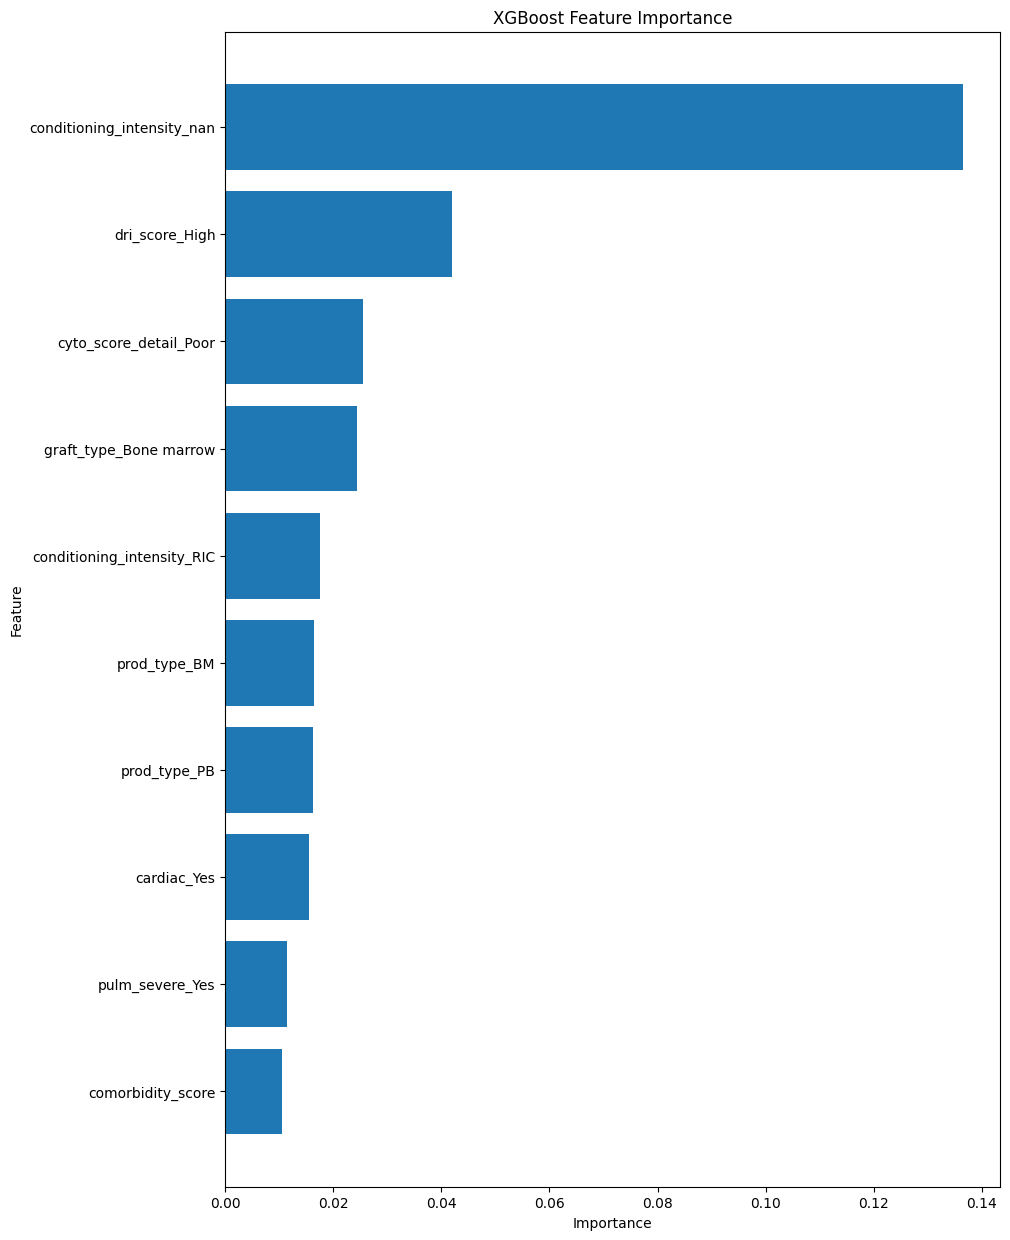

In [34]:
feature_importance = model_xgb.feature_importances_
cols=train.columns
cols=cols.drop(['efs','efs_time','ID','y'])
importance_df = pd.DataFrame({
    "Feature": cols,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)[:10]
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [35]:
pred_xgb

array([0.64042158, 0.31858497, 0.72515141])

In [36]:
submission = pd.DataFrame({
    'ID': test_encoded["ID"],
    'prediction':pred_xgb})
submission.to_csv('submission.csv', index=False)

In [37]:
submission

,ID,prediction
28800,28800,0.640422
28801,28801,0.318585
28802,28802,0.725151


### Refrences

https://www.kaggle.com/code/rajan3208/cibmtr-hct/notebook

https://www.kaggle.com/code/kendontcare11/public-classifier-cat-xgb-lb-0-688

https://www.kaggle.com/code/debobratadutta/cibmtr-lgb-xgb-ensemble